<a href="https://colab.research.google.com/github/SouzaCadu/Time-Series/blob/master/Time_series_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Projeto para o estudo de modelos de machine learning aplicados a séries temporais

Esse projeto aborda o uso de modelos de machine learning aplicados a séries temporais comparando os resultados com os modelos estatísiticos clássicos.

A partir de dados obtidos no Kaggle [(Web Traffic Time Series Forecasting)](https://www.kaggle.com/c/web-traffic-time-series-forecasting), foi selecionado um tema de interesse, a partir do qual foi aplicado o pipeline de machine learning composto pela análise dos dados, tratamento da série temporal, criação de features e aplicação dos modelos.


# Importanto as bibliotecas necessárias ao projeto

In [0]:
import numpy as np
import pandas as pd
from pandas import read_csv
import matplotlib.pyplot as plt
import seaborn as sns
import re
import missingno as msno
import math as math
from scipy import stats
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt

from fbprophet import Prophet

import sklearn as sk
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit 

tscv = TimeSeriesSplit(n_splits=10)

# importando as bibliotecas dos modelos
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LassoCV, RidgeCV
from xgboost import XGBRegressor 

from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization

from itertools import product                    # some useful functions

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

import logging
logging.getLogger().setLevel(logging.ERROR)

In [3]:
# Importanto o dataset para um pandas DataFrame e lendo os primeiros registros

df_train = pd.DataFrame(pd.read_csv('train_1.csv',index_col='Page').fillna(0))
df_train.head()

2015-07-01  ...  2016-12-31
Page                                                            ...            
2NE1_zh.wikipedia.org_all-access_spider                   18.0  ...        20.0
2PM_zh.wikipedia.org_all-access_spider                    11.0  ...        20.0
3C_zh.wikipedia.org_all-access_spider                      1.0  ...        17.0
4minute_zh.wikipedia.org_all-access_spider                35.0  ...        11.0
52_Hz_I_Love_You_zh.wikipedia.org_all-access_sp...         0.0  ...        10.0

[5 rows x 550 columns]

In [4]:
# lendo os registros finais do arquivo

df_train.tail()

2015-07-01  ...  2016-12-31
Page                                                           ...            
Miss_A_zh.wikipedia.org_all-access_all-agents           892.0  ...       624.0
Missing9_zh.wikipedia.org_all-access_all-agents           0.0  ...       526.0
Monstar_zh.wikipedia.org_all-access_all-agents          293.0  ...       139.0
Mrs._Cop_2_zh.wikipedia.org_all-access_all-agents         0.0  ...       154.0
NBA_zh.wikipedia.org_all-access_all-agents              655.0  ...         0.0

[5 rows x 550 columns]

In [5]:
# informações sobre o dataframe

df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28065 entries, 2NE1_zh.wikipedia.org_all-access_spider to NBA_zh.wikipedia.org_all-access_all-agents
Columns: 550 entries, 2015-07-01 to 2016-12-31
dtypes: float64(550)
memory usage: 118.0+ MB


In [6]:
# formato do arquivo, linhas e colunas

df_train.shape

(28065, 550)

In [7]:
# checagem dos dados

df_train.isnull().any().describe()

count       550
unique        1
top       False
freq        550
dtype: object

## Análise exploratória da base

In [0]:
def extractPageFeatures(df, key1='Page', index=False):
    """
    Input df: pandas DataFrame/Series
    key: string, column name
    index: boolean False: default, return index numerico
    True: returns Page as index returns pandas DataFrame X with feature columns
    
    Exemplos:
    
    s = pd.Series(['2NE1_zh.wikipedia.org_all-access_spider',
    'AKB48_en.wikipedia.org_all-access_spider',
    'Angelababy_zh.wikipedia.org_all-access_mobile'])
    
    Xp = extractPageFeatures(s)
    print(Xp)
        Name        Language    Access      Agent
    --  ----------  ----------  ----------  -------
     0  2NE1        zh          all-access  spider
     1  AKB48       en          all-access  spider
     2  Angelababy  zh          all-access  mobile
    
    """
    fnames = ['Name','Language','Access','Agent']
    fnamedict = dict(zip(range(len(fnames)),fnames))
    if type(df) == pd.DataFrame:
        ser = df[key1]
    else:
        ser = df
    X = ser.str.extract(
    '(.+)_(\w{2})\.wiki.+_(.+)_(.+)',expand=True).rename(columns=fnamedict)
    if index:
        X['Page']=ser.values
        X.set_index('Page',inplace=True)
    return X

In [9]:
# extração das features e criação de um dataframe

tmp = extractPageFeatures(df_train.index,index=True)
cat_f_names = tmp.columns.tolist()
df_train = df_train.join(tmp)
tmp=None
df_train.iloc[:5,-5:]

2016-12-31  ...   Agent
Page                                                            ...        
2NE1_zh.wikipedia.org_all-access_spider                   20.0  ...  spider
2PM_zh.wikipedia.org_all-access_spider                    20.0  ...  spider
3C_zh.wikipedia.org_all-access_spider                     17.0  ...  spider
4minute_zh.wikipedia.org_all-access_spider                11.0  ...  spider
52_Hz_I_Love_You_zh.wikipedia.org_all-access_sp...        10.0  ...  spider

[5 rows x 5 columns]

In [10]:
# label encoder das variaveis caegoricas

lookup_c_i = dict(zip(cat_f_names,[LabelEncoder()]*4))
lookup_c_i

{'Access': LabelEncoder(),
 'Agent': LabelEncoder(),
 'Language': LabelEncoder(),
 'Name': LabelEncoder()}

In [11]:
# inclusão das colunas com as features extraídas 

df_train[['{}_en'.format(n) for n in cat_f_names]] = df_train[cat_f_names].apply(lambda col: lookup_c_i[col.name].fit_transform(col.astype(str)))
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28065 entries, 2NE1_zh.wikipedia.org_all-access_spider to NBA_zh.wikipedia.org_all-access_all-agents
Columns: 558 entries, 2015-07-01 to Agent_en
dtypes: float64(550), int64(4), object(4)
memory usage: 120.9+ MB


In [12]:
df_train.head()

2015-07-01  ...  Agent_en
Page                                                            ...          
2NE1_zh.wikipedia.org_all-access_spider                   18.0  ...         2
2PM_zh.wikipedia.org_all-access_spider                    11.0  ...         2
3C_zh.wikipedia.org_all-access_spider                      1.0  ...         2
4minute_zh.wikipedia.org_all-access_spider                35.0  ...         2
52_Hz_I_Love_You_zh.wikipedia.org_all-access_sp...         0.0  ...         2

[5 rows x 558 columns]

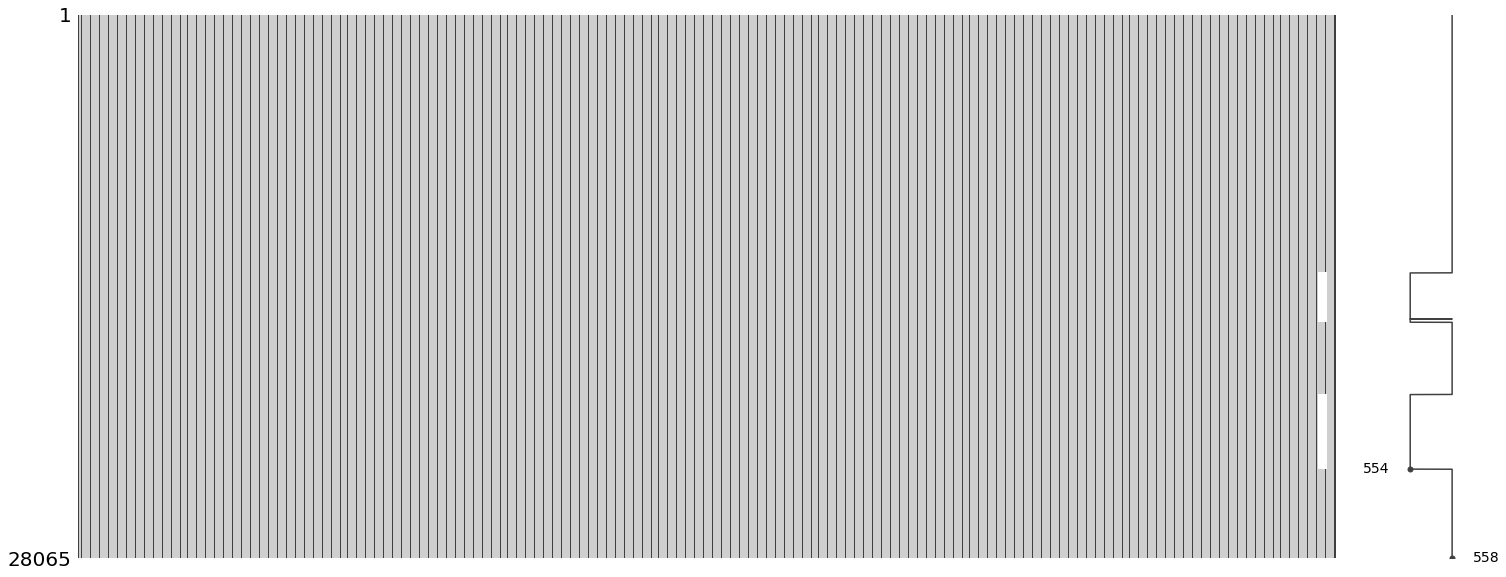

In [13]:
# avaliação da distribuição de missing para todo o dataframe

msno.matrix(df_train);

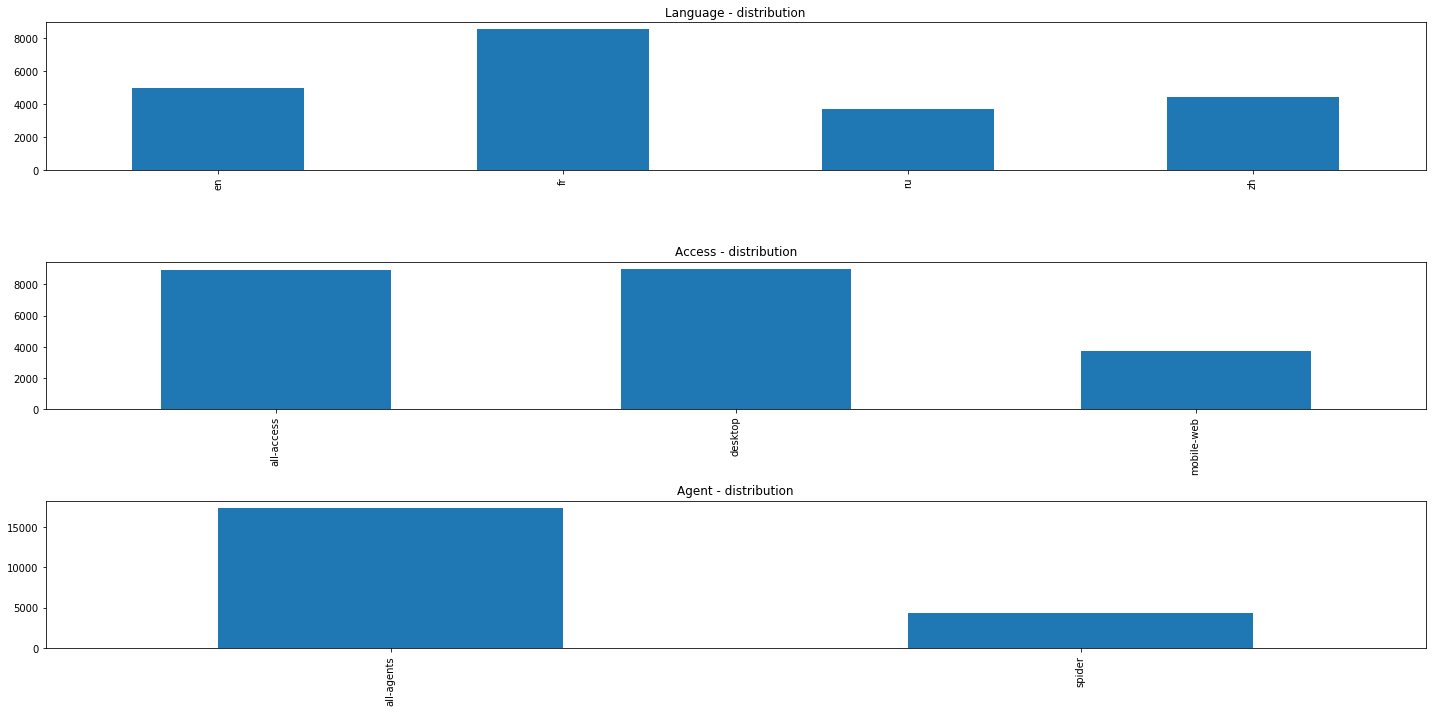

In [14]:
# plot dos gráficos com os valores em cada uma das variavéis extraídas do nome
# do site

fig, axs = plt.subplots(3, 1, figsize=(20, 10))

df_train["Language"].value_counts().sort_index().plot.bar(ax=axs[0])
axs[0].set_title('Language - distribution')

df_train["Access"].value_counts().sort_index().plot.bar(ax=axs[1])
axs[1].set_title('Access - distribution')

df_train["Agent"].value_counts().sort_index().plot.bar(ax=axs[2])
axs[2].set_title('Agent - distribution')

plt.tight_layout()

A maior concentração de pesquisas por língua é em inglês, sem diferenciação por tipo de serviço e meio de acesso.

## Seleção tema de interesse
### Páginas das temporadas 2014/2015 e 2015/2016 da NFL em inglês, por qualquer dispositivo e tipo de acesso

In [19]:
df_train1 = pd.DataFrame(df_train[(df_train.index).str.contains("nfl_season", case=False)])
df_train1

2015-07-01  ...  Agent_en
Page                                                            ...          
2015_NFL_season_en.wikipedia.org_desktop_all-ag...       971.0  ...         0
2016_NFL_season_en.wikipedia.org_desktop_all-ag...        17.0  ...         0

[2 rows x 558 columns]

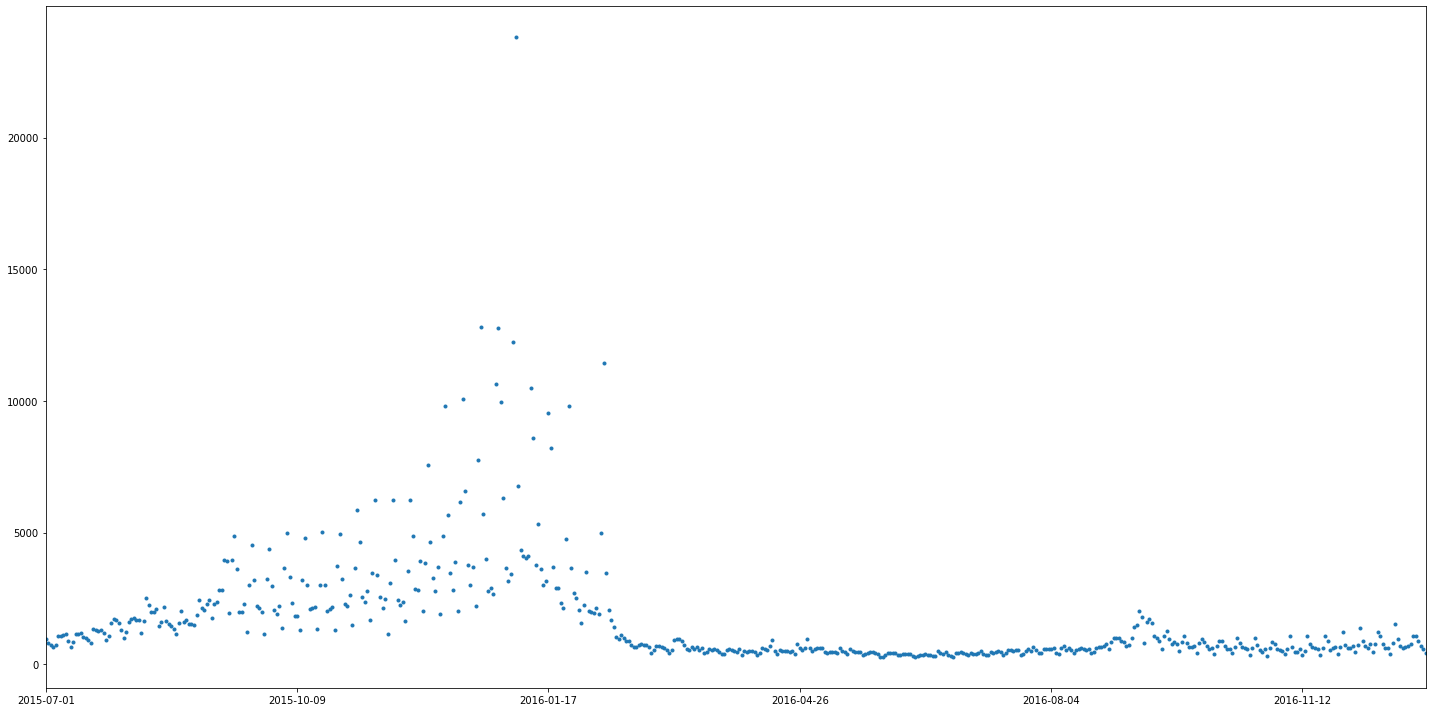

In [20]:
fig = plt.figure(facecolor='w', figsize=(20, 10))
ax = fig.add_subplot(111)
sample_series = df_train1.iloc[0, :550]
sample_series.plot(style=".", ax=ax)
plt.tight_layout();

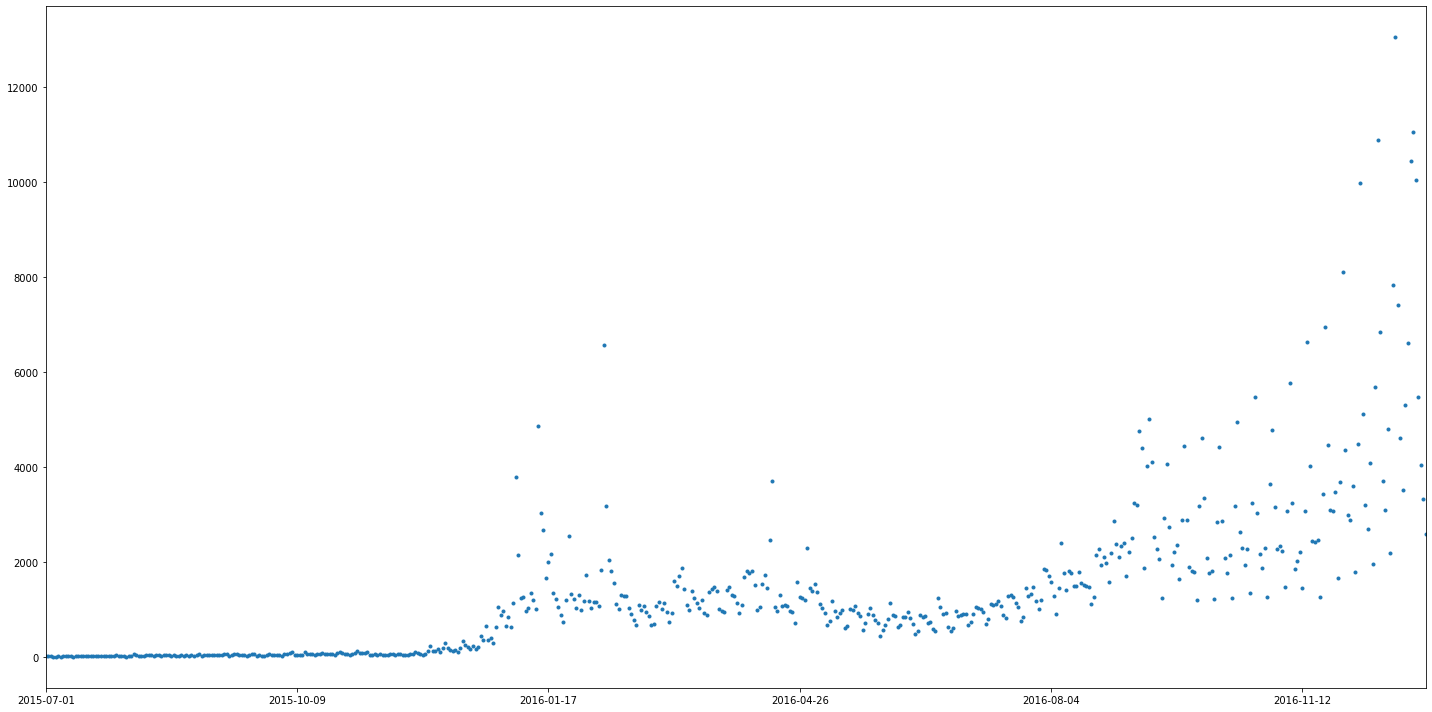

In [21]:
fig = plt.figure(facecolor='w', figsize=(20, 10))
ax = fig.add_subplot(111)
sample_series = df_train1.iloc[1, :550]
sample_series.plot(style=".", ax=ax)
plt.tight_layout();

In [22]:
df_train1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2 entries, 2015_NFL_season_en.wikipedia.org_desktop_all-agents to 2016_NFL_season_en.wikipedia.org_desktop_all-agents
Columns: 558 entries, 2015-07-01 to Agent_en
dtypes: float64(550), int64(4), object(4)
memory usage: 8.8+ KB


In [23]:
df_train1.columns

Index(['2015-07-01', '2015-07-02', '2015-07-03', '2015-07-04', '2015-07-05',
       '2015-07-06', '2015-07-07', '2015-07-08', '2015-07-09', '2015-07-10',
       ...
       '2016-12-30', '2016-12-31', 'Name', 'Language', 'Access', 'Agent',
       'Name_en', 'Language_en', 'Access_en', 'Agent_en'],
      dtype='object', length=558)

In [24]:
df_train1.reset_index(inplace=True)
df_train1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Columns: 559 entries, Page to Agent_en
dtypes: float64(550), int64(4), object(5)
memory usage: 8.9+ KB


In [25]:
df_train1 = pd.DataFrame(df_train1.groupby(['Language']).agg('sum'))
df_train1.reset_index(inplace=True)
df_train1 = df_train1.drop(columns=['Language', 'Name_en', 'Language_en', 'Access_en','Agent_en'])
df_train1.head()

2015-07-01  2015-07-02  2015-07-03  ...  2016-12-29  2016-12-30  2016-12-31
0       988.0       813.0       743.0  ...      4734.0      3883.0      3020.0

[1 rows x 550 columns]

In [26]:
y = df_train1.as_matrix()[0]
nfl = pd.DataFrame({ 'ds': df_train1.T.index.values, 'y': y})
nfl.head()

ds      y
0  2015-07-01  988.0
1  2015-07-02  813.0
2  2015-07-03  743.0
3  2015-07-04  664.0
4  2015-07-05  719.0

In [27]:
nfl.y.describe().T

count      550.000000
mean      3077.205455
std       2594.670055
min        664.000000
25%       1553.750000
50%       2273.000000
75%       3670.750000
max      27601.000000
Name: y, dtype: float64

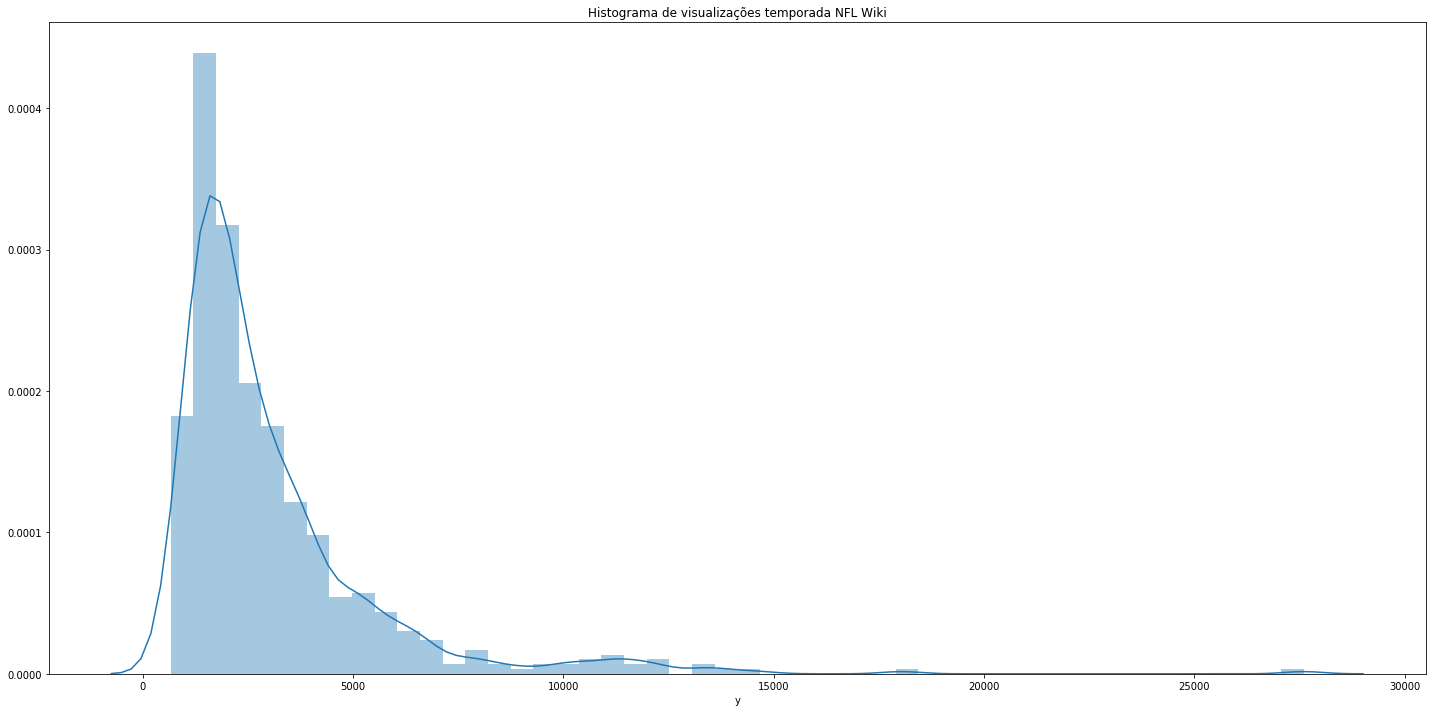

In [28]:
plt.figure(figsize=(20,10))
ax = plt.title('Histograma de visualizações temporada NFL Wiki')
sns.distplot(nfl.y)
plt.tight_layout();

In [29]:
from scipy.stats import kstest, ks_2samp

params = list(nfl.drop(['ds'],axis=1))

print("Teste de Normalidade de Kolgomorov-Smirnov")
print()

for p in params:
    print(p,':', kstest(nfl[p], 'norm', alternative = 'less'))  

Teste de Normalidade de Kolgomorov-Smirnov

y : KstestResult(statistic=1.0, pvalue=0.0)


In [30]:
nfl_ex = nfl.set_index(pd.DatetimeIndex(nfl['ds']))
nfl_ex.drop(['ds'], axis = 1, inplace = True)
nfl_ex.head()

y
ds               
2015-07-01  988.0
2015-07-02  813.0
2015-07-03  743.0
2015-07-04  664.0
2015-07-05  719.0

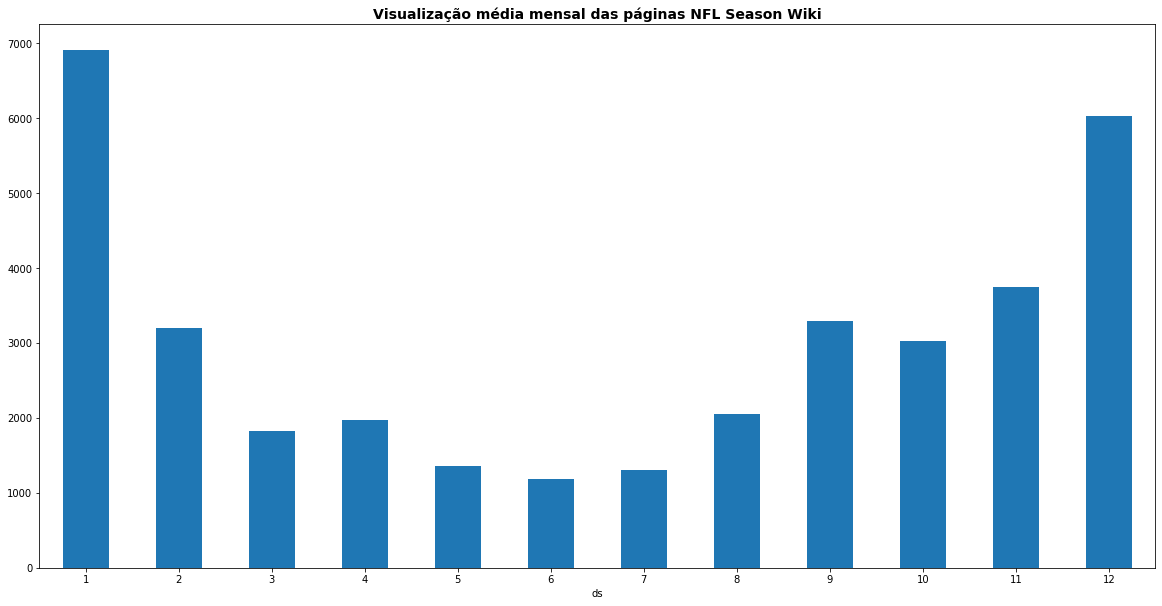

In [31]:
plt.figure(figsize=(20,10))
plt.grid(True)
plt.title('Visualização média mensal das páginas NFL Season Wiki', fontsize=14, fontweight='bold')
nfl_ex.groupby(nfl_ex.index.month).y.mean().plot.bar(rot=0);

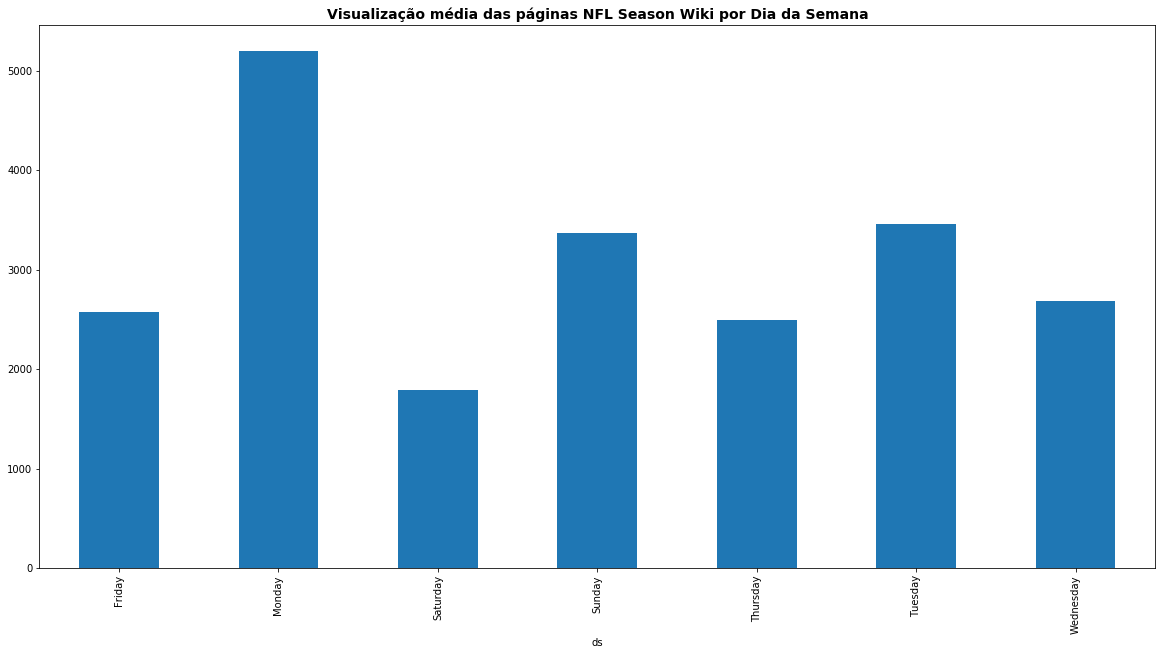

In [35]:
plt.figure(figsize=(20,10))
plt.grid(True)
plt.title('Visualização média das páginas NFL Season Wiki por Dia da Semana', fontsize=14, fontweight='bold')
nfl_ex.groupby(nfl_ex.index.day_name()).y.mean().plot.bar();

## Explorando a serie temporal com o Prophet

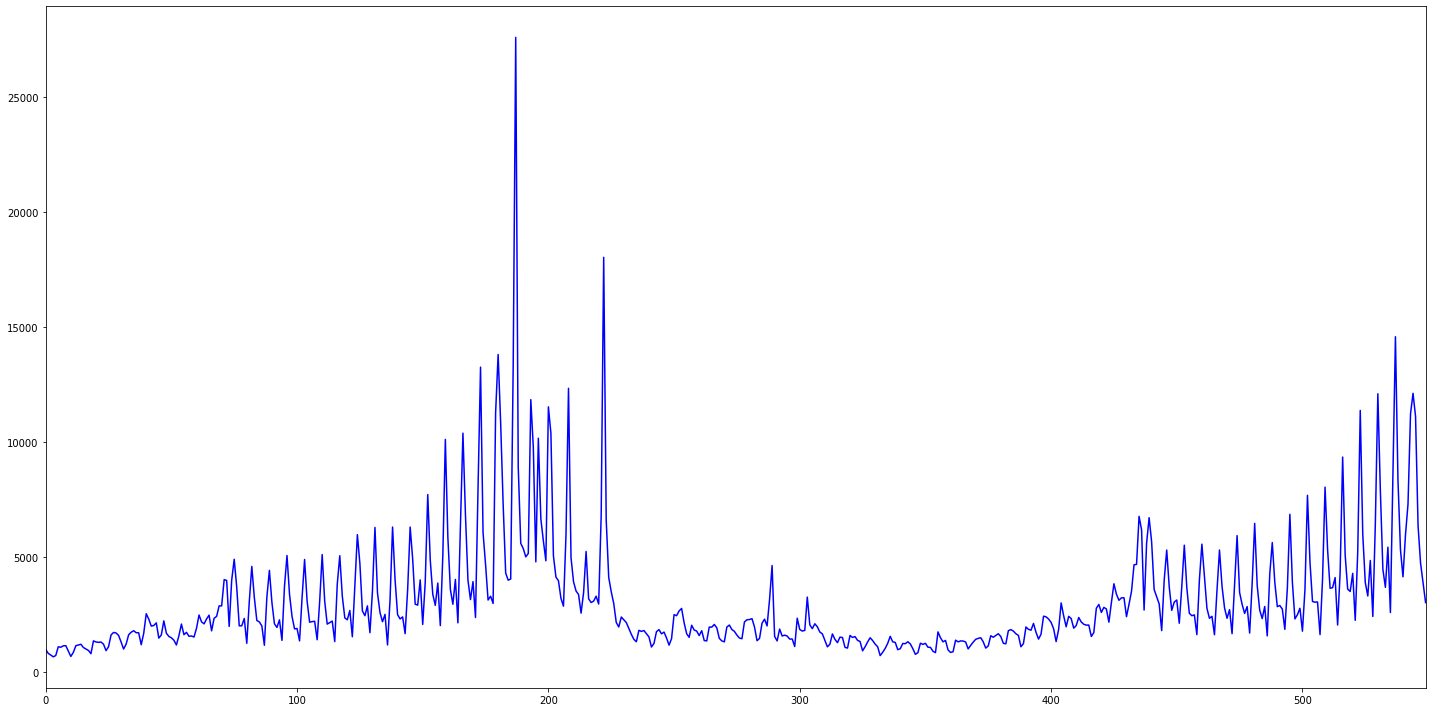

In [36]:
# Print da série diária de visualizações das páginas das temporadas 2014/2015 e 2015/2016 da NFL
fig = plt.figure(facecolor='w', figsize=(20, 10))
ax = fig.add_subplot(111)
sample_series = nfl.y
sample_series.plot(style="-b", ax=ax)
plt.tight_layout();

### Decomposição da série temporal a partir do Prophet

In [37]:
# Train test split para uma janela de 30 dia de predição
prediction_size = 30
train_df = nfl[:-prediction_size]
train_df.tail()

ds       y
515  2016-11-27  4347.0
516  2016-11-28  9351.0
517  2016-11-29  5089.0
518  2016-11-30  3610.0
519  2016-12-01  3506.0

In [40]:
# Prophet com intervalo de confiança de 95%
m = Prophet(interval_width=0.95)
m.fit(train_df)
future = m.make_future_dataframe(periods=prediction_size,freq='D')
forecast = m.predict(future)
forecast.tail()

ds        trend  ...  multiplicative_terms_upper         yhat
545 2016-12-27  4742.016733  ...                         0.0  5038.997119
546 2016-12-28  4759.658352  ...                         0.0  4439.806764
547 2016-12-29  4777.299972  ...                         0.0  4303.821341
548 2016-12-30  4794.941591  ...                         0.0  4344.548194
549 2016-12-31  4812.583210  ...                         0.0  3611.496773

[5 rows x 16 columns]

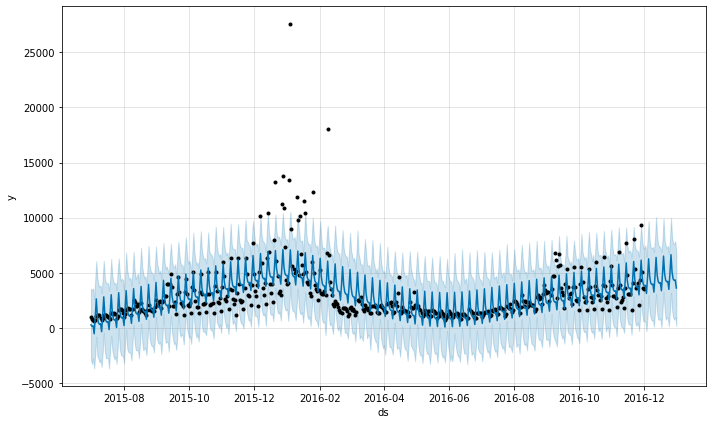

In [41]:
# Print do forecast
m.plot(forecast, uncertainty=True, plot_cap=True);

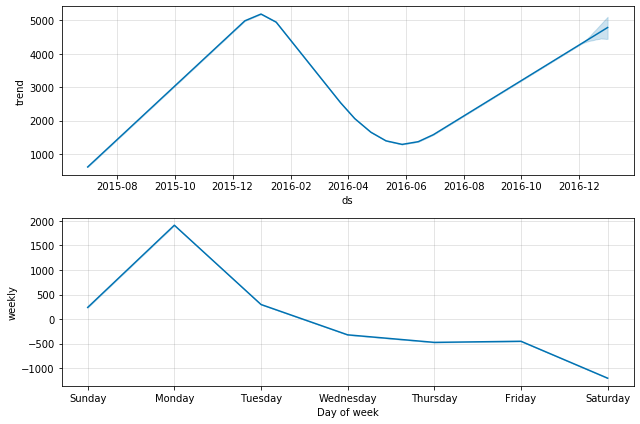

In [0]:
# Print das componentes do forecast
m.plot_components(forecast);

In [0]:
# comparando os resultados preditos com os resultados reais
def make_comparison_dataframe(historical, forecast):
    """Join the history with the forecast.
    
       The resulting dataset will contain columns 'yhat', 'yhat_lower', 'yhat_upper' and 'y'.
    """
    return forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(historical.set_index('ds'))

In [44]:
cmp_df = make_comparison_dataframe(nfl, forecast)
cmp_df.tail()

yhat   yhat_lower   yhat_upper        y
ds                                                        
2016-12-27  5038.997119  1655.725499  8202.600652  11117.0
2016-12-28  4439.806764   929.689915  7636.625666   6367.0
2016-12-29  4303.821341   747.105351  7637.860546   4734.0
2016-12-30  4344.548194   996.214217  7843.575918   3883.0
2016-12-31  3611.496773   155.299018  6834.354019   3020.0

In [0]:
# calculo do erro do modelo

def calculate_baseline_errors(df, prediction_size):
    """Calculate MAPE of the forecast.
    
       Args:
           df: joined dataset with 'y' and 'yhat' columns.
           prediction_size: number of days at the end to predict.
    """
    
    # Make a copy
    df = df.copy()
    
    # Now we calculate the values of e_i and p_i according to the formulas given in the article above.
    df['e'] = df['y'] - df['yhat']
    df['p'] = 100 * df['e'] / df['y']
    
    # Recall that we held out the values of the last `prediction_size` days
    # in order to predict them and measure the quality of the model. 
    
    # Now cut out the part of the data which we made our prediction for.
    predicted_part = df[-prediction_size:]
    
    # Define the function that averages absolute error values over the predicted part.
    error_mean = lambda error_name: np.mean(np.abs(predicted_part[error_name]))
       
    # Now we can calculate MAPE and MAE and return the resulting dictionary of errors.
    return {'Baseline model Prophet MAPE': error_mean('p')}

In [46]:
for err_name, err_value in calculate_baseline_errors(cmp_df, prediction_size).items():
    print(err_name, err_value)

Baseline model Prophet MAPE 28.57443375623628


In [0]:
def smape(y_true, y_pred):
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 200.0
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0
    return np.nanmean(diff)

In [48]:
print('Baseline model Prophet SMAPE:{}'.format(smape(cmp_df['y'], cmp_df['yhat'])))

Baseline model Prophet SMAPE:36.15922344131116


## Explorando os modelos da estatística clássica

In [49]:
nfl.set_index('ds')
nfl.head()

ds      y
0  2015-07-01  988.0
1  2015-07-02  813.0
2  2015-07-03  743.0
3  2015-07-04  664.0
4  2015-07-05  719.0

In [0]:
# Function for mean_absolute_percentage_error
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [0]:
# Function to plot moving average together with original data

def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 

    """
    # Calculate and plot rolling mean
    rolling_mean = series.rolling(window=window).mean()
    
    plt.figure(figsize=(20,10))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
    
    # Plot original series values
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

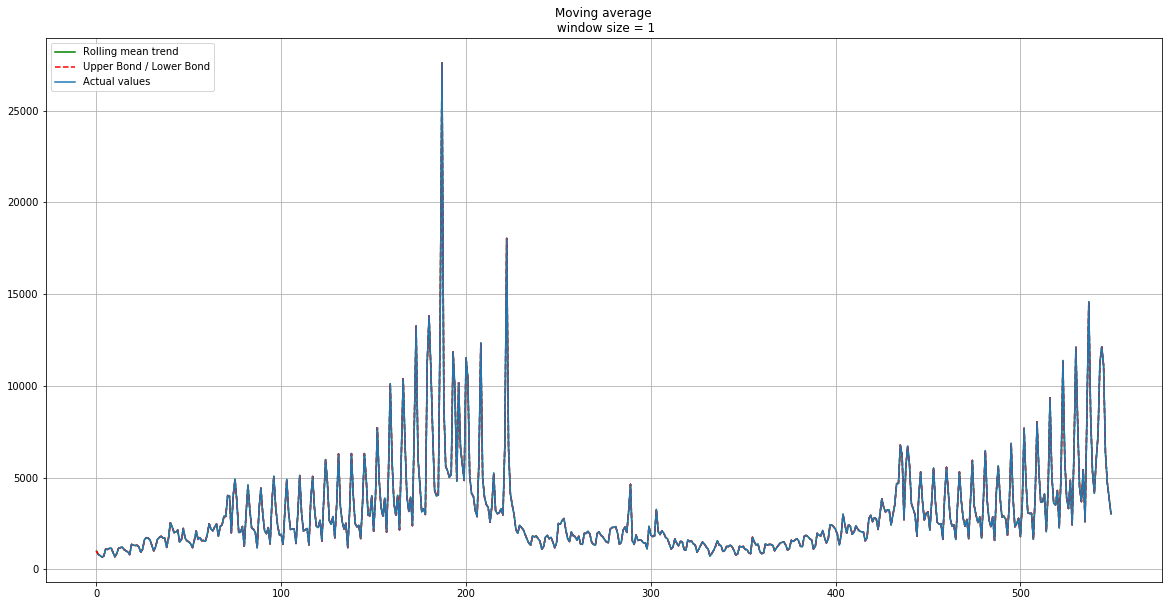

In [52]:
plotMovingAverage(nfl.y, 1, plot_intervals=True) 

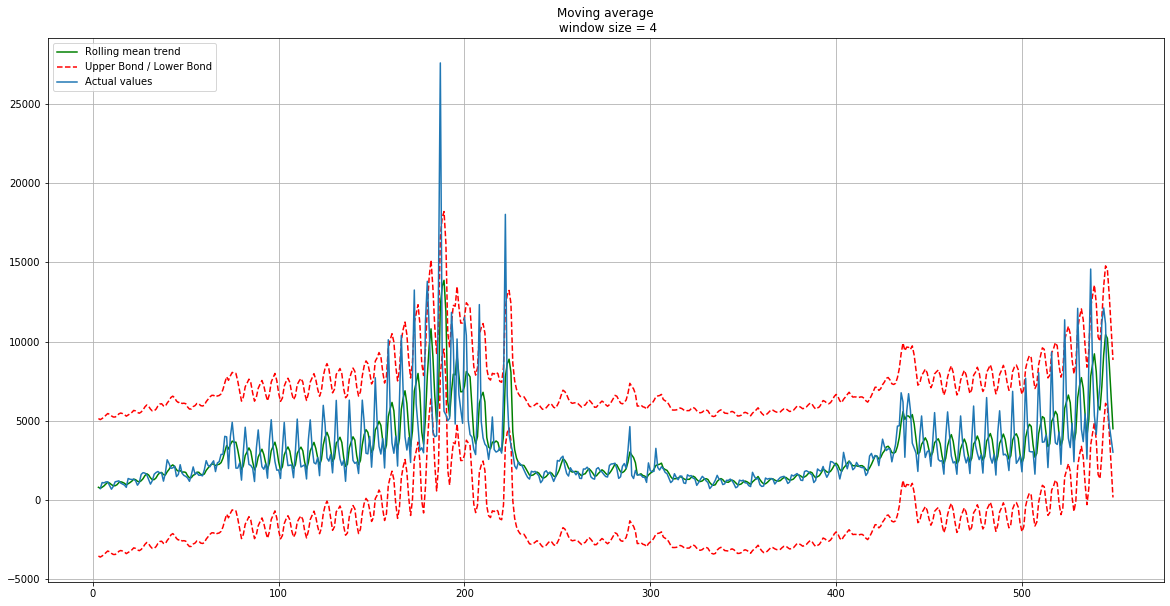

In [53]:
plotMovingAverage(nfl.y, 4, plot_intervals=True) 

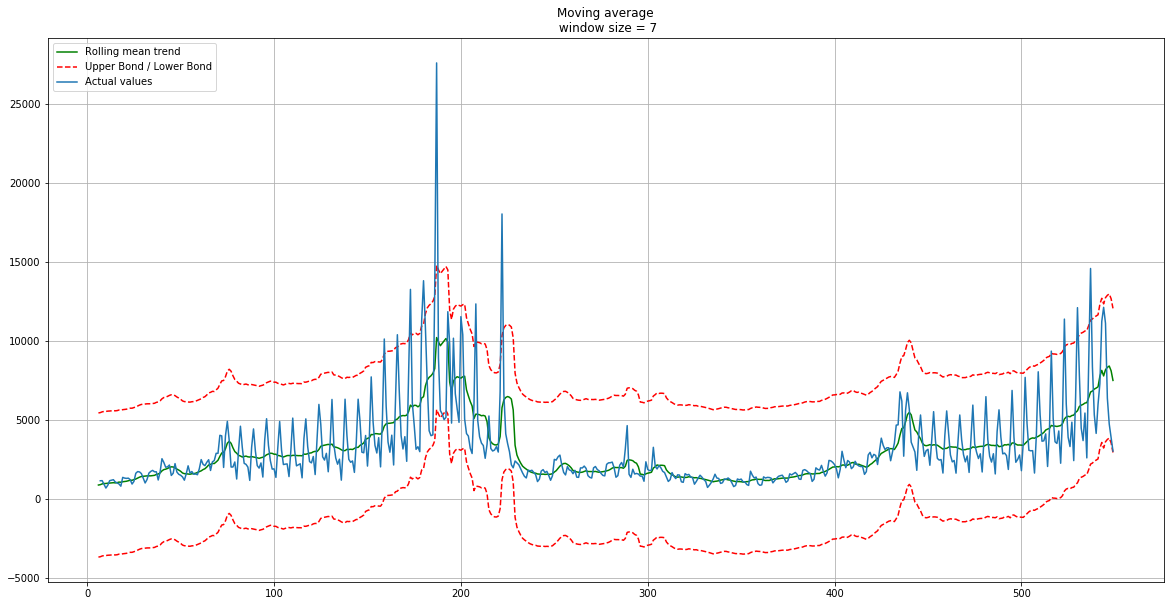

In [54]:
plotMovingAverage(nfl.y, 7, plot_intervals=True) 

In [0]:
# Function to calculate exponential smoothing

def exponential_smoothing(series, alpha):
    """
        series - dataset with timestamps
        alpha - float [0.0, 1.0], smoothing parameter
    """
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [0]:
# Function to plot exponential smoothing

def plotExponentialSmoothing(series, alphas):
    """
        Plots exponential smoothing with different alphas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters
        
    """
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(20, 10))
        for alpha in alphas:
            plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
        plt.plot(series.values, "c", label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Exponential Smoothing")
        plt.grid(True);

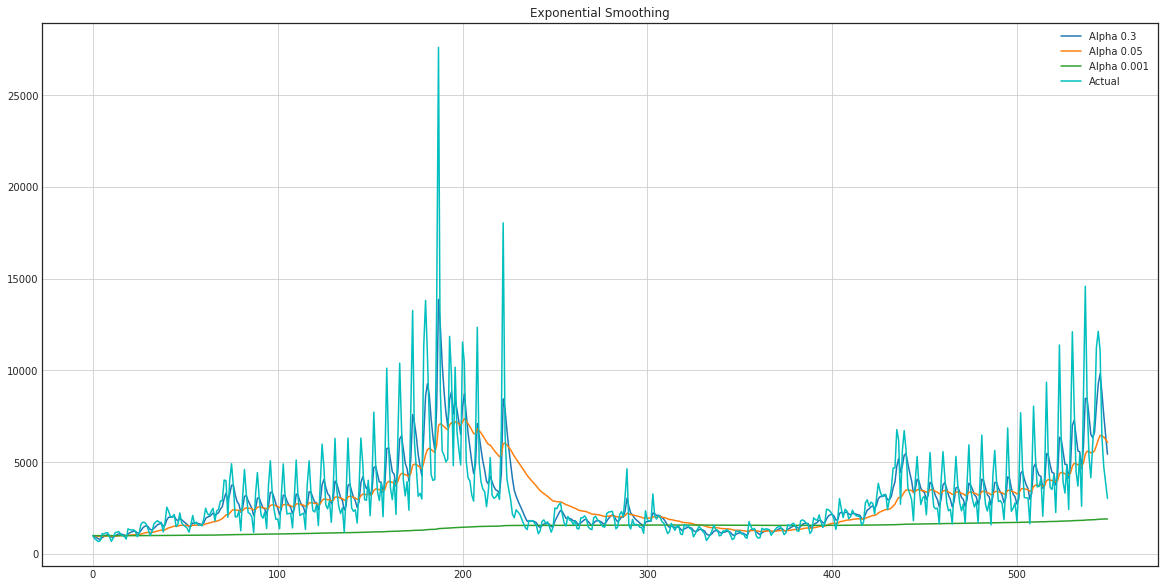

In [57]:
# Plot ads exponential smooting fuctions fos alphas ([0.3, 0.05])
plotExponentialSmoothing(nfl.y, [0.3, 0.05, 0.001])

In [0]:
# Function to calculate doble exponential smoothing

def double_exponential_smoothing(series, alpha, beta):
    """
        series - dataset with timeseries
        alpha - float [0.0, 1.0], smoothing parameter for level
        beta - float [0.0, 1.0], smoothing parameter for trend
    """
    # first value is same as series
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result

In [0]:
# Function to plot doble exponential smoothing

def plotDoubleExponentialSmoothing(series, alphas, betas):
    """
        Plots double exponential smoothing with different alphas and betas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters for level
        betas - list of floats, smoothing parameters for trend
    """
    
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(20, 10))
        for alpha in alphas:
            for beta in betas:
                plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
        plt.plot(series.values, label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Double Exponential Smoothing")
        plt.grid(True)

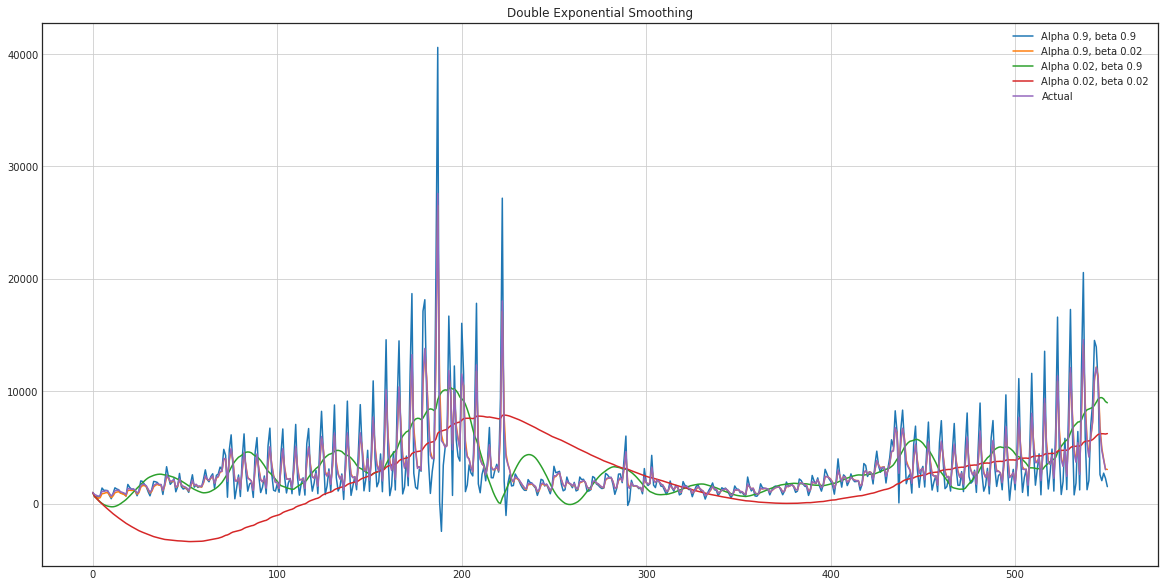

In [60]:
# Plot for ads series, alphas and betas ([0.9, 0.02])
plotDoubleExponentialSmoothing(nfl.y, alphas=[0.9, 0.02], betas=[0.9, 0.02])

### Modelagem com Holt Winters

In [0]:
# Class definition to calculate Holt-Winters triple exponential smoothing

class HoltWinters:
    
    """
    Holt-Winters model with the anomalies detection using Brutlag method
    
    # series - initial time series
    # slen - length of a season
    # alpha, beta, gamma - Holt-Winters model coefficients
    # n_preds - predictions horizon
    # scaling_factor - sets the width of the confidence interval by Brutlag (usually takes values from 2 to 3)
    
    """
    
    
    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor
        
        
    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series[i+self.slen] - self.series[i]) / self.slen
        return sum / self.slen  
    
    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series)/self.slen)
        # let's calculate season averages
        for j in range(n_seasons):
            season_averages.append(sum(self.series[self.slen*j:self.slen*j+self.slen])/float(self.slen))
        # let's calculate initial values
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen*j+i]-season_averages[j]
            seasonals[i] = sum_of_vals_over_avg/n_seasons
        return seasonals   

          
    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []
        
        seasonals = self.initial_seasonal_components()
        
        for i in range(len(self.series)+self.n_preds):
            if i == 0: # components initialization
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i%self.slen])
                
                self.PredictedDeviation.append(0)
                
                self.UpperBond.append(self.result[0] + 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                
                self.LowerBond.append(self.result[0] - 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                continue
                
            if i >= len(self.series): # predicting
                m = i - len(self.series) + 1
                self.result.append((smooth + m*trend) + seasonals[i%self.slen])
                
                # when predicting we increase uncertainty on each step
                self.PredictedDeviation.append(self.PredictedDeviation[-1]*1.01) 
                
            else:
                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha*(val-seasonals[i%self.slen]) + (1-self.alpha)*(smooth+trend)
                trend = self.beta * (smooth-last_smooth) + (1-self.beta)*trend
                seasonals[i%self.slen] = self.gamma*(val-smooth) + (1-self.gamma)*seasonals[i%self.slen]
                self.result.append(smooth+trend+seasonals[i%self.slen])
                
                # Deviation is calculated according to Brutlag algorithm.
                self.PredictedDeviation.append(self.gamma * np.abs(self.series[i] - self.result[i]) 
                                               + (1-self.gamma)*self.PredictedDeviation[-1])
                     
            self.UpperBond.append(self.result[-1] + 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.LowerBond.append(self.result[-1] - 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i%self.slen])

In [0]:
# Dependencies

from sklearn.model_selection import TimeSeriesSplit # you have everything done for you

# Function to calculate Cross Validation fos Time Series

def timeseriesCVscore(params, series, loss_function=mean_squared_error, slen=24):
    """
        Returns error on CV  
        
        params - vector of parameters for optimization
        series - dataset with timeseries
        slen - season length for Holt-Winters model
    """
    # errors array
    errors = []
    
    values = series.values
    alpha, beta, gamma = params
    
    # set the number of folds for cross-validation
    tscv = TimeSeriesSplit(n_splits=3) 
    
    # iterating over folds, train model on each, forecast and calculate error
    for train, test in tscv.split(values):

        model = HoltWinters(series=values[train], slen=slen, 
                            alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()
        
        predictions = model.result[-len(test):]
        actual = values[test]
        error = loss_function(predictions, actual)
        errors.append(error)
        
    return np.mean(np.array(errors))

In [63]:
%%time
data = nfl.y[:-30] # leave some data for testing

# initializing model parameters alpha, beta and gamma
x = [0, 0, 0] 

# Minimizing the loss function 
opt = minimize(timeseriesCVscore, x0=x, 
               args=(data, mean_squared_error), 
               method="TNC", bounds = ((0, 1), (0, 1), (0, 1))
              )

# Take optimal values...
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

# ...and train the model with them, forecasting for the next 60 days
model = HoltWinters(data, slen = 4, 
                    alpha = alpha_final, 
                    beta = beta_final, 
                    gamma = gamma_final, 
                    n_preds = 60, scaling_factor = 3)
model.triple_exponential_smoothing()

0.4102388171035034 0.0015810490632670038 0.24273974880725868
CPU times: user 4.53 s, sys: 3.24 ms, total: 4.53 s
Wall time: 4.54 s


In [0]:
# Function to plot Holt-Winters 

def plotHoltWinters(series, plot_intervals=False, plot_anomalies=False):
    """
        series - dataset with timeseries
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 
    """
    
    plt.figure(figsize=(20, 10))
    plt.plot(model.result, label = "Model")
    plt.plot(series.values, label = "Actual")
    error = mean_absolute_percentage_error(series.values, model.result[:len(series)])
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    
    if plot_anomalies:
        anomalies = np.array([np.NaN]*len(series))
        anomalies[series.values<model.LowerBond[:len(series)]] = \
            series.values[series.values<model.LowerBond[:len(series)]]
        anomalies[series.values>model.UpperBond[:len(series)]] = \
            series.values[series.values>model.UpperBond[:len(series)]]
        plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    if plot_intervals:
        plt.plot(model.UpperBond, "r--", alpha=0.5, label = "Up/Low confidence")
        plt.plot(model.LowerBond, "r--", alpha=0.5)
        plt.fill_between(x=range(0,len(model.result)), y1=model.UpperBond, 
                         y2=model.LowerBond, alpha=0.2, color = "grey")    
        
    plt.vlines(len(series), ymin=min(model.LowerBond), ymax=max(model.UpperBond), linestyles='dashed')
    plt.axvspan(len(series)-20, len(model.result), alpha=0.3, color='lightgrey')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc="best", fontsize=13);

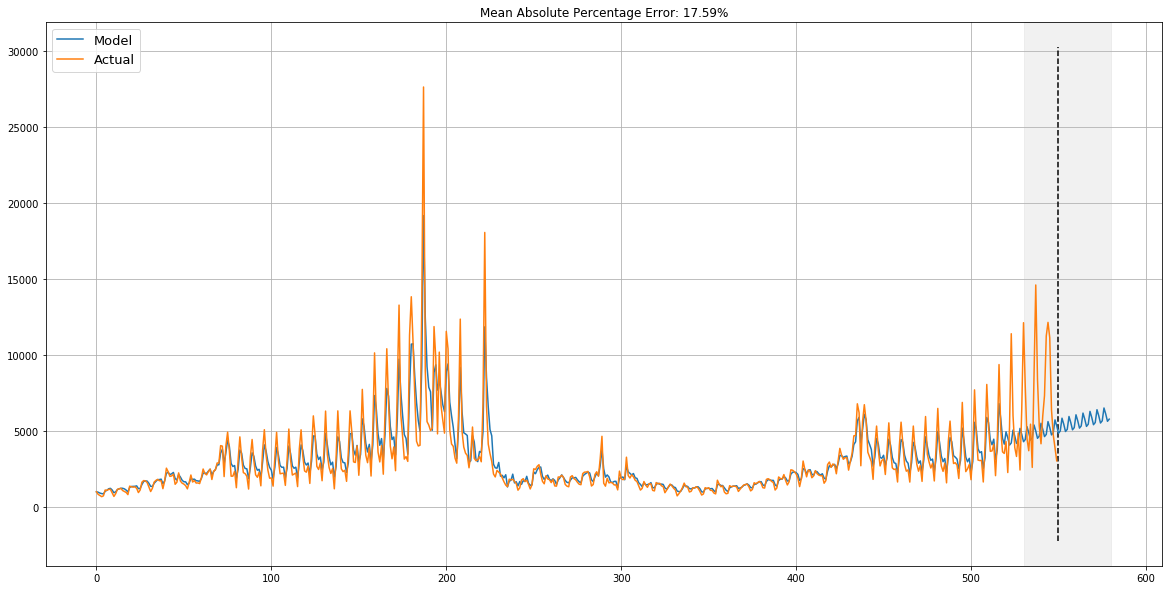

In [65]:
plotHoltWinters(nfl.y)

In [66]:
print('Holt Winters model SMAPE:{}'.format(smape(nfl.y, model.result[:len(nfl.y)])))

Holt Winters model SMAPE:16.643238585727445


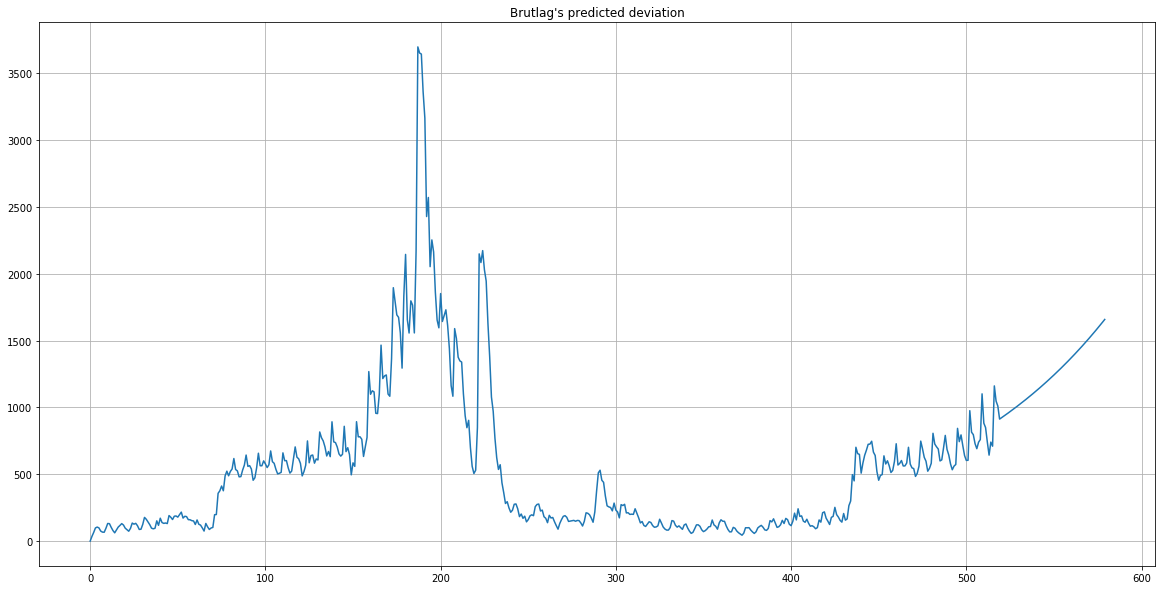

In [67]:
# Standard deviation for ads Holt Winters trained model
plt.figure(figsize=(20, 10))
plt.plot(model.PredictedDeviation)
plt.grid(True)
plt.axis('tight')
plt.title("Brutlag's predicted deviation");

### Utilizando a abordagem econometrica

In [68]:
#ADF-test(Original-time-series)
res = sm.tsa.adfuller(nfl.y.dropna(),regression='ct')
print('p-value:{}'.format(res[1]))

p-value:0.7915681464777627


In [69]:
#ADF-test(differenced-time-series)
res = sm.tsa.adfuller(nfl.y.diff().dropna(),regression='c')
print('p-value:{}'.format(res[1]))

p-value:6.5953977704808306e-09


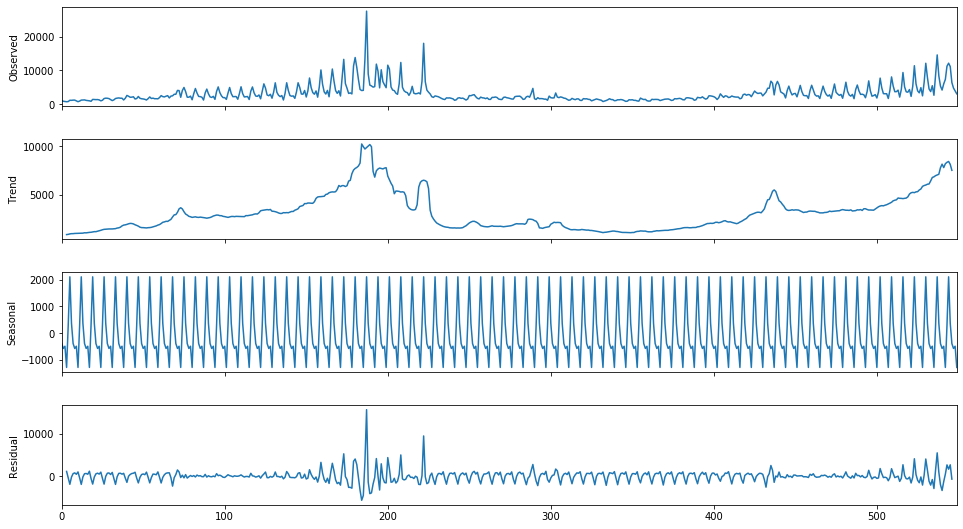

In [70]:
# decompondo os sinais da serie
res = sm.tsa.seasonal_decompose(nfl.y.dropna(),freq=7)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
plt.show()

In [0]:
# Function to plot ACF and PACF Dickey-Fuller test

def tsplot(y, lags=None, figsize=(20, 10), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

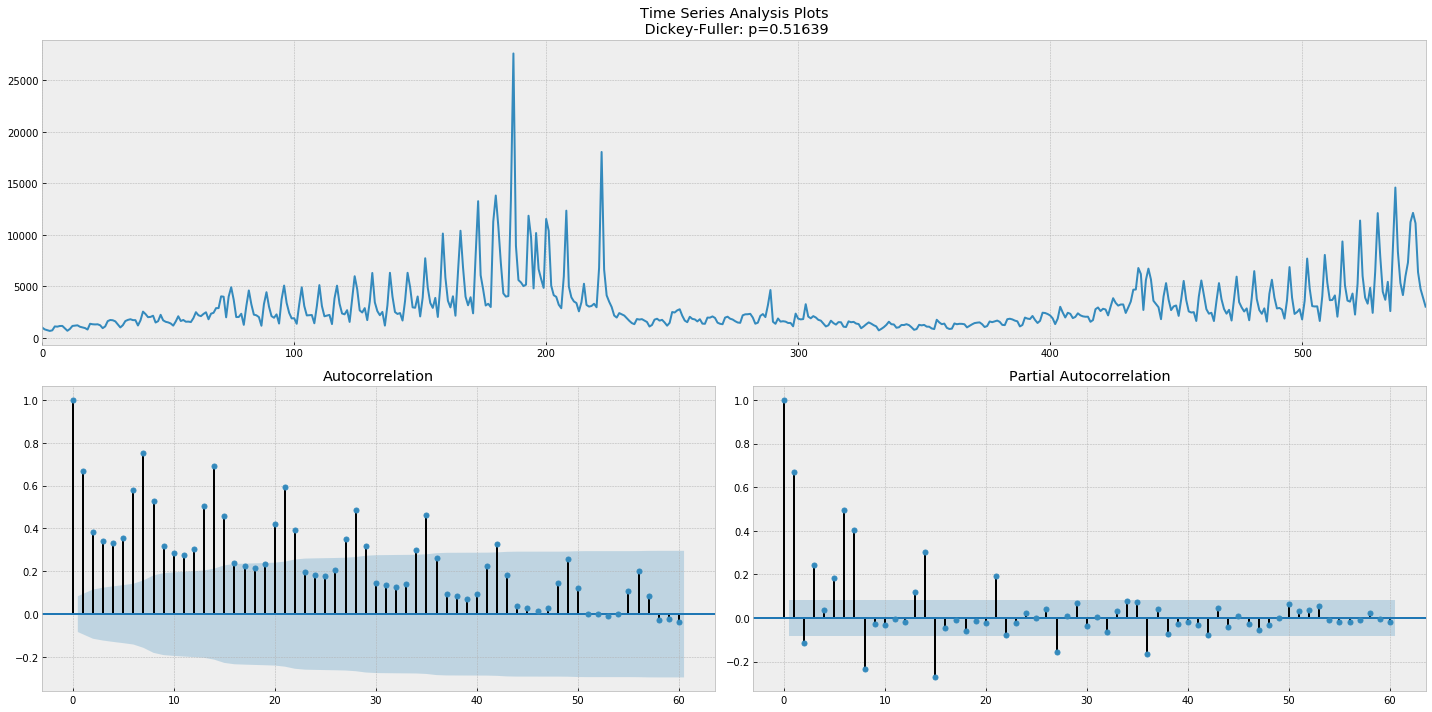

In [72]:
# plot for views with 60 lags - intervalo total teste de estacionariedade
tsplot(nfl.y, lags=60)

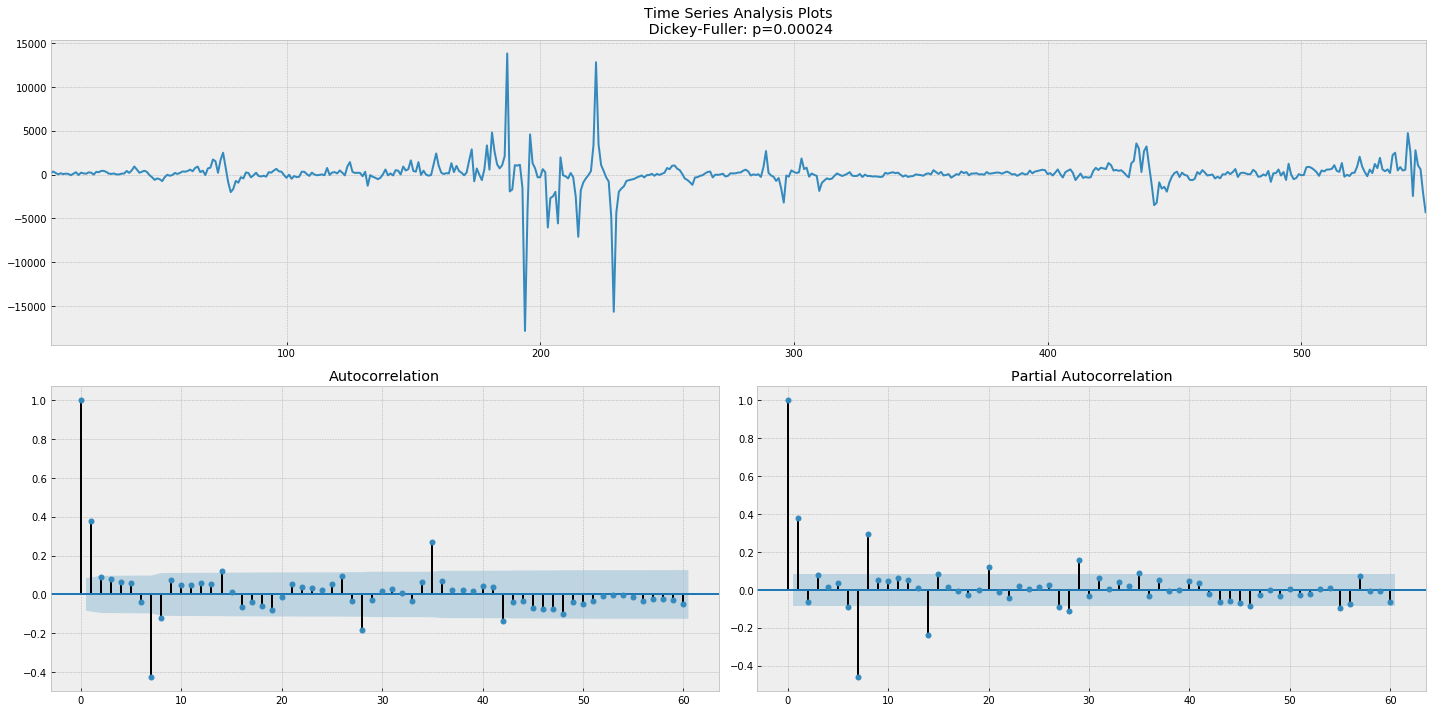

In [73]:
# teste de estacionariedade com janela de uma semana
nfl_diff = nfl.y - nfl.y.shift(7)
tsplot(nfl_diff[7:], lags=60)

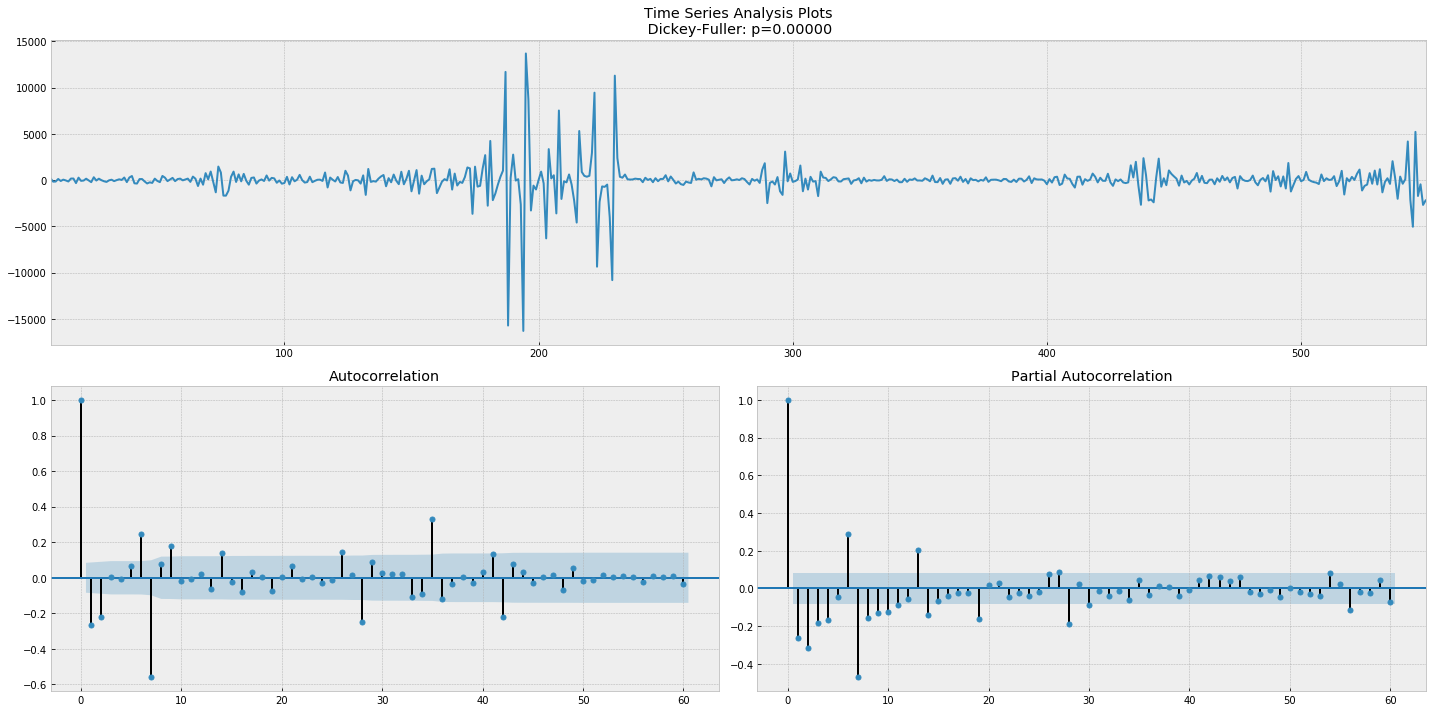

In [74]:
# teste de estacionariedade com uma semana + 1 dia
nfl_diff = nfl_diff - nfl_diff.shift(1)
tsplot(nfl_diff[7+1:], lags=60)

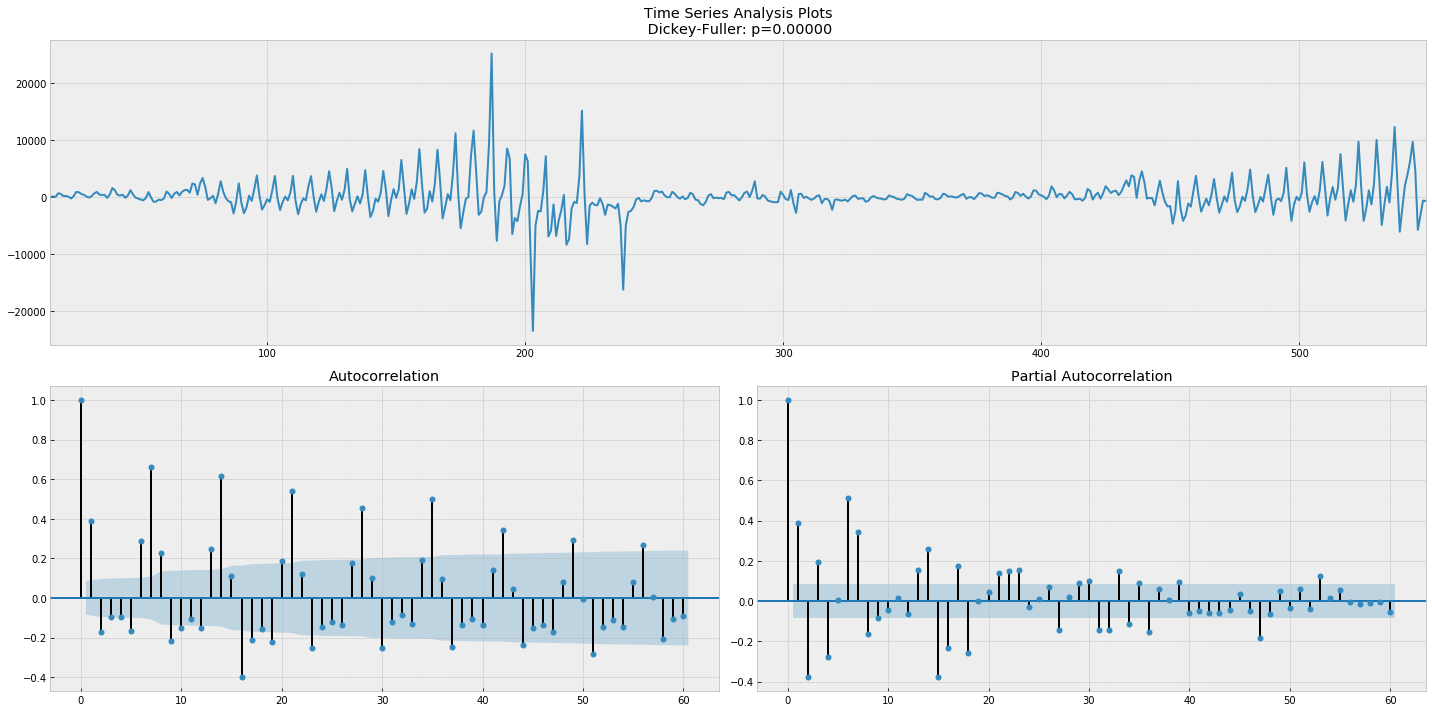

In [75]:
# janela de estacionariedade com janela de 16 dias
nfl_diff1 = nfl.y - nfl.y.shift(16)
tsplot(nfl_diff1[16:], lags=60)

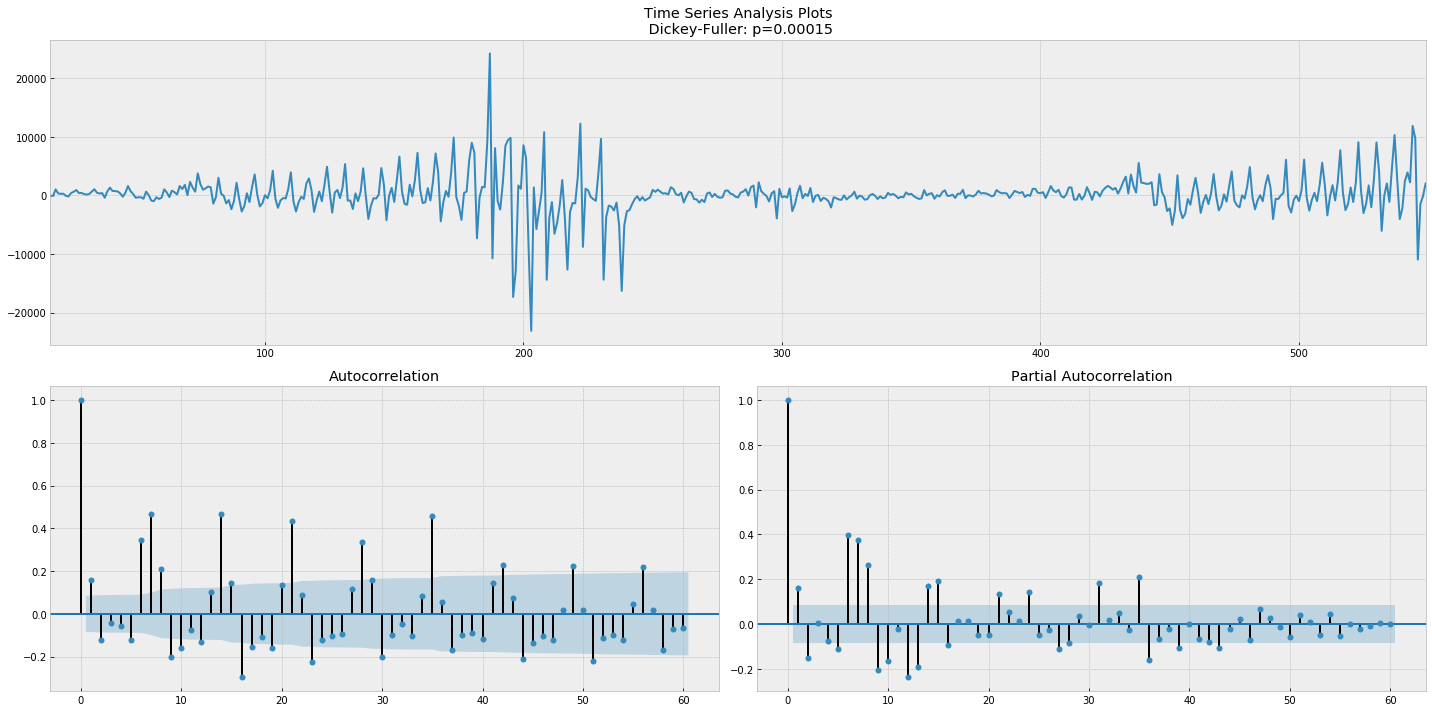

In [76]:
# janela de estacionariedade com janela de 16 dias + 1 dia
nfl_diff1 = nfl_diff1 - nfl_diff.shift(1)
tsplot(nfl_diff1[16+1:], lags=60)

### Aplicação do modelo ARIMA

In [0]:
nfl.to_csv("nfl.csv", sep=',', index=False)

In [78]:
%%time
# Function for mean_absolute_percentage_error
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
	# prepare training dataset
	train_size = int(len(X) * 0.66)
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		model = ARIMA(history, order=arima_order)
		model_fit = model.fit(disp=0)
		yhat = model_fit.forecast()[0]
		predictions.append(yhat)
		history.append(test[t])
	# calculate out of sample error
	error = mean_absolute_percentage_error(test, predictions)
	return error

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					mape = evaluate_arima_model(dataset, order)
					if mape < best_score:
						best_score, best_cfg = mape, order
					print('ARIMA%s MAPE=%.3f' % (order,mape))
				except:
					continue
	print('Best ARIMA%s MAPE=%.3f' % (best_cfg, best_score))

# load dataset
series = read_csv('nfl.csv', header=0, index_col=0)
# evaluate parameters
p_values = [6, 7]
d_values = range(0, 2)
q_values = range(0, 4)
warnings.filterwarnings("ignore")
evaluate_models(series.values, p_values, d_values, q_values)

ARIMA(6, 0, 0) MAPE=21.868
ARIMA(6, 0, 1) MAPE=19.938
ARIMA(6, 0, 2) MAPE=19.110
ARIMA(6, 0, 3) MAPE=17.448
ARIMA(6, 1, 0) MAPE=17.988
ARIMA(6, 1, 1) MAPE=16.991
ARIMA(6, 1, 2) MAPE=17.007
ARIMA(6, 1, 3) MAPE=16.977
ARIMA(7, 0, 0) MAPE=17.645
ARIMA(7, 0, 1) MAPE=16.493
ARIMA(7, 0, 2) MAPE=16.480
ARIMA(7, 0, 3) MAPE=16.424
ARIMA(7, 1, 0) MAPE=16.973
ARIMA(7, 1, 1) MAPE=16.985
ARIMA(7, 1, 2) MAPE=16.972
ARIMA(7, 1, 3) MAPE=16.965
Best ARIMA(7, 0, 3) MAPE=16.424
CPU times: user 1h 57min 10s, sys: 1h 12min 23s, total: 3h 9min 33s
Wall time: 1h 44min 20s


In [88]:
%%time

def smape(y_true, y_pred):
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 200.0
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0
    return np.nanmean(diff)

# evaluate an ARIMA model for a given order (p,d,q)
def arima_model(X, arima_order):
	# prepare training dataset
	train_size = int(len(X) * 0.66)
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		model = ARIMA(history, order=arima_order)
		model_fit = model.fit(disp=0)
		yhat = model_fit.forecast()[0]
		predictions.append(yhat)
		history.append(test[t])
	# calculate out of sample error
	error = smape(test, predictions)
	return error, test, predictions


CPU times: user 17 µs, sys: 0 ns, total: 17 µs
Wall time: 23.6 µs


In [89]:
# load dataset
%%time

series = read_csv('nfl.csv', header=0, index_col=0)
arima_order = (7, 0, 3)
arima_model(series.values, arima_order)

CPU times: user 14min 11s, sys: 10min 8s, total: 24min 19s
Wall time: 12min 24s


                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  550
Model:                     ARMA(7, 3)   Log Likelihood               -4763.856
Method:                       css-mle   S.D. of innovations           1391.724
Date:                Tue, 03 Dec 2019   AIC                           9551.713
Time:                        03:45:37   BIC                           9603.432
Sample:                    07-01-2015   HQIC                          9571.924
                         - 12-31-2016                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3238.9702    900.125      3.598      0.000    1474.759    5003.182
ar.L1.y        0.1836      0.071      2.576      0.010       0.044       0.323
ar.L2.y       -0.0601      0.077     -0.785      0.4

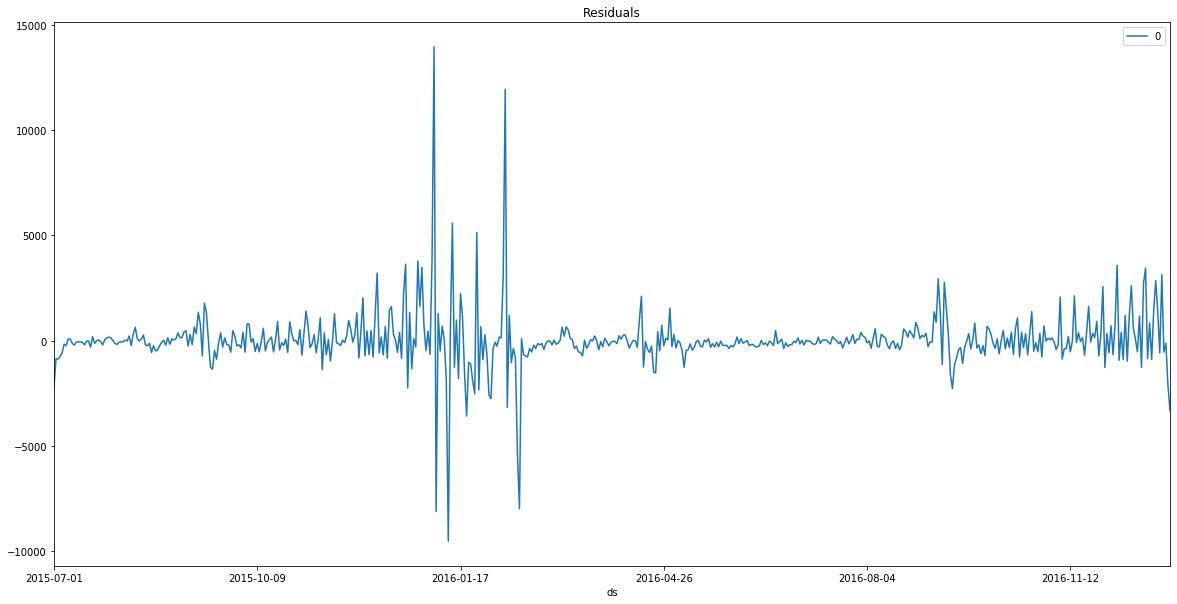

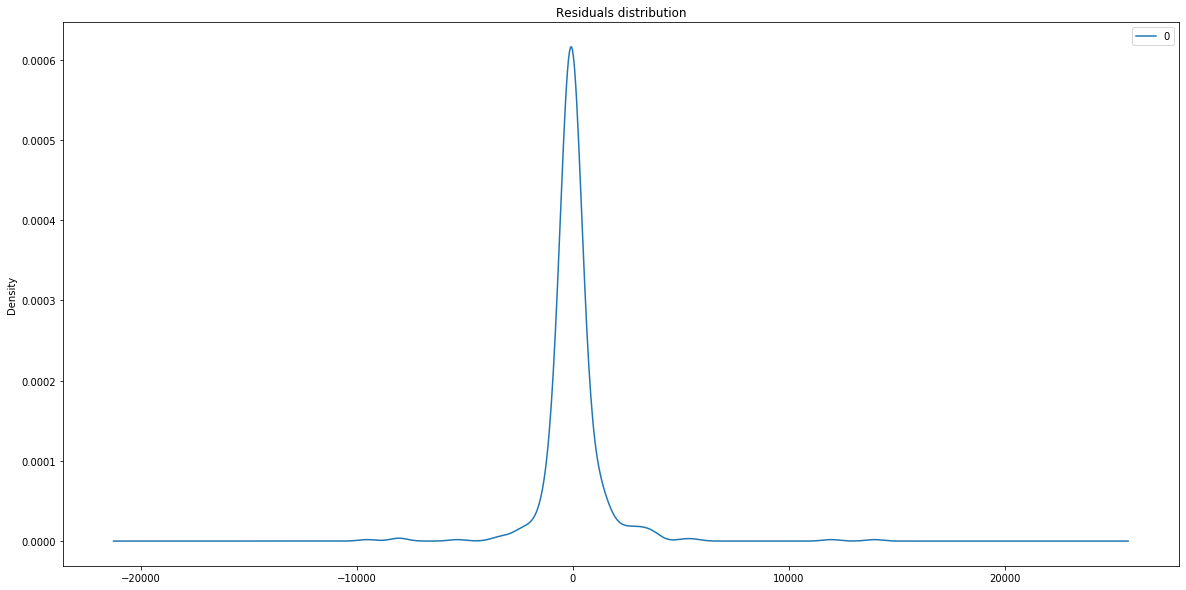

                  0
count    550.000000
mean      21.472337
std     1396.047809
min    -9528.313386
25%     -341.700266
50%      -59.687896
75%      256.450647
max    13959.965071
CPU times: user 8.49 s, sys: 5.46 s, total: 13.9 s
Wall time: 7.57 s


In [82]:
%%time
from matplotlib import pyplot
# load dataset
series = series = read_csv('nfl.csv', header=0, index_col=0)
# fit model
model = ARIMA(series, order=(7,0,3))
model_fit = model.fit(disp=0)
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot(figsize=(20, 10),title='Residuals')
pyplot.show()
# density plot of residuals
residuals.plot(kind='kde',figsize=(20, 10), title = 'Residuals distribution')
pyplot.show()
# summary stats of residuals
print(residuals.describe())

## Machine Learning

#### FB Prophet com o calendário da NFL

In [0]:
holiday_en_us = ['2015-01-01', '2015-01-19', '2015-05-25', '2015-07-03', '2015-09-07', '2015-11-26', '2015-11-27', '2015-12-25', '2016-01-01', 
                 '2016-01-18', '2016-05-30', '2016-07-04', '2016-09-05', '2016-11-11', '2016-11-24', '2016-12-26', '2017-01-01', '2017-01-02', 
                 '2017-01-16', '2017-05-29', '2017-07-04', '2017-09-04', '2017-11-10', '2017-11-23', '2017-12-25']

draft_nfl     = ['2015-04-30', '2015-05-01', '2015-05-02', '2016-04-28', '2016-04-29', '2016-04-30']

season_nfl    = ['2015-09-10', '2015-09-13', '2015-09-14', '2015-09-17', '2015-09-20', '2015-09-21', '2015-09-24', '2015-09-27', '2015-09-28',
                 '2015-10-01', '2015-10-04', '2015-10-05', '2015-10-08', '2015-10-11', '2015-10-12', '2015-10-15', '2015-10-18', '2015-10-19',
                 '2015-10-22', '2015-10-25', '2015-10-26', '2015-10-29', '2015-11-01', '2015-11-02', '2015-11-05', '2015-11-08', '2015-11-09',
                 '2015-11-12', '2015-11-15', '2015-11-16', '2015-11-19', '2015-11-22', '2015-11-23', '2015-11-26', '2015-11-29', '2015-11-30',
                 '2015-12-03', '2015-12-06', '2015-12-07', '2015-12-10', '2015-12-13', '2015-12-14', '2015-12-17', '2015-12-19', '2015-12-20',
                 '2015-12-21', '2015-12-24', '2015-12-26', '2015-12-27', '2015-12-28', '2016-09-08', '2016-09-11', '2016-09-12', '2016-09-15',
                 '2016-09-18', '2016-09-19', '2016-09-22', '2016-09-25', '2016-09-26', '2016-09-29', '2016-10-02', '2016-10-03', '2016-10-06',
                 '2016-10-09', '2016-10-10', '2016-10-13', '2016-10-16', '2016-10-17', '2016-10-20', '2016-10-23', '2016-10-24', '2016-10-27', 
                 '2016-10-30', '2016-10-31', '2016-11-03', '2016-11-06', '2016-11-07', '2016-11-10', '2016-11-13', '2016-11-14', '2016-11-17',
                 '2016-11-20', '2016-11-21', '2016-11-24', '2016-11-27', '2016-11-28', '2016-12-01', '2016-12-04', '2016-12-05', '2016-12-08',
                 '2016-12-11', '2016-12-12', '2016-12-15', '2016-12-17', '2016-12-18', '2016-12-19', '2016-12-22', '2016-12-24', '2016-12-25',
                 '2016-12-26', '2017-01-01']

sunday_nfl    = ['2015-09-13', '2015-09-20', '2015-09-27', '2015-10-04', '2015-10-11', '2015-10-18', '2015-10-25', '2015-11-01', '2015-11-08',
                 '2015-11-15', '2015-11-22', '2015-11-29', '2015-12-06', '2015-12-13', '2015-12-20', '2015-12-27', '2016-09-11', '2016-09-18',
                 '2016-09-25', '2016-10-02', '2016-10-09', '2016-10-16', '2016-10-23', '2016-10-30', '2016-11-06', '2016-11-13', '2016-11-20',
                 '2016-11-27', '2016-12-04', '2016-12-11', '2016-12-18', '2016-12-25', '2017-01-01']

playoffs_nfl = ['2015-01-03', '2016-01-04', '2015-01-10', '2015-01-11', '2015-01-18', '2016-01-07', '2016-01-08', '2016-01-14', '2016-01-15',
                '2106-01-22']

sb_nfl       = ['2015-02-01', '2016-02-05']

holidays_us = pd.DataFrame({
  'holiday': 'US_public_holiday',
  'ds': pd.to_datetime(holiday_en_us),
  'lower_window': 0,
  'upper_window': 0,
})

draft_nfl = pd.DataFrame({
  'holiday': 'Draft',
  'ds': pd.to_datetime(draft_nfl),
  'lower_window': 0,
  'upper_window': 0,
})

season_nfl = pd.DataFrame({
  'holiday': 'Season',
  'ds': pd.to_datetime(season_nfl),
  'lower_window': 0,
  'upper_window': 0,
})

sunday_nfl = pd.DataFrame({
  'holiday': 'Sunday_nfl',
  'ds': pd.to_datetime(sunday_nfl),
  'lower_window': 0,
  'upper_window': 0,
})

playoffs_nfl = pd.DataFrame({
  'holiday': 'Playoff',
  'ds': pd.to_datetime(playoffs_nfl),
  'lower_window': 0,
  'upper_window': 0,
})

sb_nfl = pd.DataFrame({
  'holiday': 'SB',
  'ds': pd.to_datetime(sb_nfl),
  'lower_window': 0,
  'upper_window': 0,
})

holidays_en = pd.concat((holidays_us,
                         draft_nfl,
                         season_nfl,
                         sunday_nfl,
                         playoffs_nfl,
                         sb_nfl))

In [91]:
# Python
# Train test split para uma janela de 30 dia de predição
prediction_size = 30
train_df1 = nfl[:-prediction_size]
train_df1.tail()

ds       y
515  2016-11-27  4347.0
516  2016-11-28  9351.0
517  2016-11-29  5089.0
518  2016-11-30  3610.0
519  2016-12-01  3506.0

In [92]:
m = Prophet(holidays=holidays_en, interval_width=0.95)
forecast = m.fit(train_df1).predict(future)
future = m.make_future_dataframe(periods=prediction_size,freq='D')
forecast = m.predict(future)
forecast.tail()

ds        trend  ...  multiplicative_terms_upper         yhat
545 2016-12-27  4242.421405  ...                         0.0  4737.456699
546 2016-12-28  4257.176288  ...                         0.0  4132.340966
547 2016-12-29  4271.931170  ...                         0.0  3484.192629
548 2016-12-30  4286.686053  ...                         0.0  3886.146520
549 2016-12-31  4301.440935  ...                         0.0  3250.236330

[5 rows x 37 columns]

In [93]:
forecast.columns

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'Draft', 'Draft_lower', 'Draft_upper', 'Playoff', 'Playoff_lower',
       'Playoff_upper', 'SB', 'SB_lower', 'SB_upper', 'Season', 'Season_lower',
       'Season_upper', 'Sunday_nfl', 'Sunday_nfl_lower', 'Sunday_nfl_upper',
       'US_public_holiday', 'US_public_holiday_lower',
       'US_public_holiday_upper', 'additive_terms', 'additive_terms_lower',
       'additive_terms_upper', 'holidays', 'holidays_lower', 'holidays_upper',
       'weekly', 'weekly_lower', 'weekly_upper', 'multiplicative_terms',
       'multiplicative_terms_lower', 'multiplicative_terms_upper', 'yhat'],
      dtype='object')

In [0]:
forecast[(forecast['Draft'] + forecast['Season'] + forecast['Sunday_nfl'] + forecast['Playoff'] + forecast['SB'] + forecast['US_public_holiday']).abs() > 0][
        ['ds', 'Draft', 'Season', 'Sunday_nfl', 'Playoff', 'SB', 'US_public_holiday']][-10:]

ds  Draft      Season  Sunday_nfl  Playoff   SB  US_public_holiday
529 2016-12-11    0.0  899.075405   -132.8829      0.0  0.0           0.000000
530 2016-12-12    0.0  899.075405      0.0000      0.0  0.0           0.000000
533 2016-12-15    0.0  899.075405      0.0000      0.0  0.0           0.000000
535 2016-12-17    0.0  899.075405      0.0000      0.0  0.0           0.000000
536 2016-12-18    0.0  899.075405   -132.8829      0.0  0.0           0.000000
537 2016-12-19    0.0  899.075405      0.0000      0.0  0.0           0.000000
540 2016-12-22    0.0  899.075405      0.0000      0.0  0.0           0.000000
542 2016-12-24    0.0  899.075405      0.0000      0.0  0.0           0.000000
543 2016-12-25    0.0  899.075405   -132.8829      0.0  0.0           0.000000
544 2016-12-26    0.0  899.075405      0.0000      0.0  0.0        -335.977759

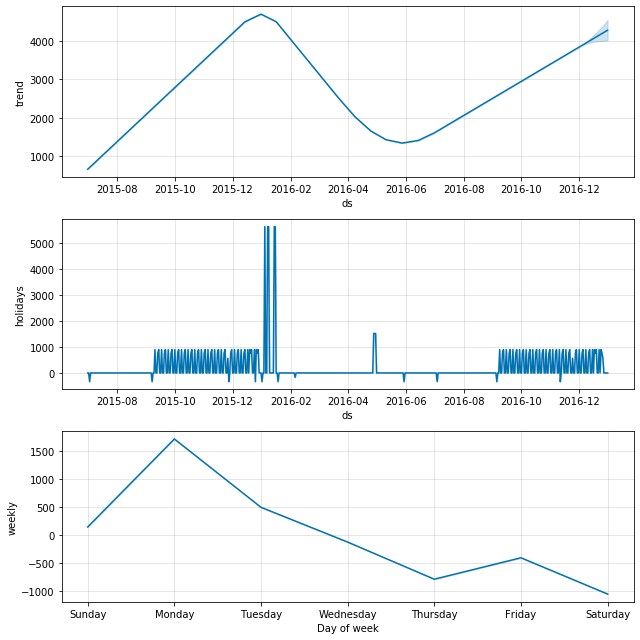

In [0]:
# Python
fig = m.plot_components(forecast);

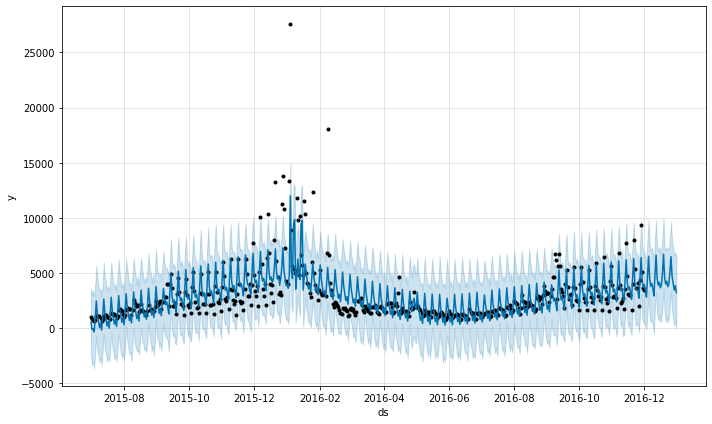

In [0]:
m.plot(forecast, uncertainty=True, plot_cap=True);

In [0]:
cmp_df = make_comparison_dataframe(nfl, forecast)
cmp_df.tail()

yhat   yhat_lower   yhat_upper        y
ds                                                        
2016-12-27  4724.073454  1596.908241  7977.121094  11117.0
2016-12-28  4119.019651   886.108778  7311.517443   6367.0
2016-12-29  3472.097113   228.186393  6603.082575   4734.0
2016-12-30  3868.539618   820.010236  6910.849736   3883.0
2016-12-31  3236.691087   -63.923000  6518.269680   3020.0

In [0]:
def calculate_prophet_errors(df, prediction_size):
    """Calculate MAPE and MAE of the forecast.
    
       Args:
           df: joined dataset with 'y' and 'yhat' columns.
           prediction_size: number of days at the end to predict.
    """
    
    # Make a copy
    df = df.copy()
    
    # Now we calculate the values of e_i and p_i according to the formulas given in the article above.
    df['e'] = df['y'] - df['yhat']
    df['p'] = 100 * df['e'] / df['y']
    
    # Recall that we held out the values of the last `prediction_size` days
    # in order to predict them and measure the quality of the model. 
    
    # Now cut out the part of the data which we made our prediction for.
    predicted_part = df[-prediction_size:]
    
    # Define the function that averages absolute error values over the predicted part.
    error_mean = lambda error_name: np.mean(np.abs(predicted_part[error_name]))
       
    # Now we can calculate MAPE and MAE and return the resulting dictionary of errors.
    return {'Prophet model w/ holidays MAPE': error_mean('p')}

In [0]:
for err_name, err_value in calculate_prophet_errors(cmp_df, prediction_size).items():
    print(err_name, err_value)

Prophet model w/ holidays MAPE 29.827244322505923


In [0]:
print('Prophet model w/ holidays SMAPE:{}'.format(smape(cmp_df['y'], cmp_df['yhat'])))

Prophet model w/ holidays SMAPE:39.19015635492932


#### Regularização das datas importantes

In [0]:
m = Prophet(holidays=holidays_en, interval_width=0.95, holidays_prior_scale=0.05)
forecast = m.fit(train_df1).predict(future)
future = m.make_future_dataframe(periods=prediction_size,freq='D')
forecast = m.predict(future)
forecast.tail()

ds        trend   yhat_lower   yhat_upper  trend_lower  \
545 2016-12-27  4300.227059  1674.812662  8046.368610  4116.784241   
546 2016-12-28  4315.305029  1080.492250  7248.145891  4120.525965   
547 2016-12-29  4330.382999   244.322962  6587.356631  4120.195945   
548 2016-12-30  4345.460969   843.176451  7102.993606  4119.518949   
549 2016-12-31  4360.538939    66.070187  6487.665165  4123.261660   

     trend_upper  Draft  Draft_lower  Draft_upper  Playoff  ...  holidays  \
545  4531.244259    0.0          0.0          0.0      0.0  ...       0.0   
546  4556.858031    0.0          0.0          0.0      0.0  ...       0.0   
547  4582.238649    0.0          0.0          0.0      0.0  ...       0.0   
548  4609.779614    0.0          0.0          0.0      0.0  ...       0.0   
549  4636.055821    0.0          0.0          0.0      0.0  ...       0.0   

     holidays_lower  holidays_upper       weekly  weekly_lower  weekly_upper  \
545             0.0             0.0   463.897127    463.897127    463.897127   
546             0.0             0.0  -154.812573   -154.812573   -154.812573   
547             0.0             0.0  -724.821124   -724.821124   -724.821124   
548             0.0             0.0  -389.397768   -389.397768   -389.397768   
549             0.0             0.0 -1071.214451  -1071.214451  -1071.214451   

     multiplicative_terms  multiplicative_terms_lower  \
545                   0.0                         0.0   
546                   0.0                         0.0   
547                   0.0                         0.0   
548                   0.0                         0.0   
549                   0.0                         0.0   

     multiplicative_terms_upper         yhat  
545                         0.0  4764.124187  
546                         0.0  4160.492456  
547                         0.0  3605.561875  
548                         0.0  3956.063201  
549                         0.0  3289.324488  

[5 rows x 37 columns]

In [0]:
forecast[(forecast['Draft'] + forecast['Season'] + forecast['Sunday_nfl'] + forecast['Playoff'] + forecast['SB'] + forecast['US_public_holiday']).abs() > 0][
        ['ds', 'Draft', 'Season', 'Sunday_nfl', 'Playoff', 'SB', 'US_public_holiday']][-10:]

ds  Draft     Season  Sunday_nfl  Playoff   SB  US_public_holiday
529 2016-12-11    0.0  774.02057  -38.300372      0.0  0.0           0.000000
530 2016-12-12    0.0  774.02057    0.000000      0.0  0.0           0.000000
533 2016-12-15    0.0  774.02057    0.000000      0.0  0.0           0.000000
535 2016-12-17    0.0  774.02057    0.000000      0.0  0.0           0.000000
536 2016-12-18    0.0  774.02057  -38.300372      0.0  0.0           0.000000
537 2016-12-19    0.0  774.02057    0.000000      0.0  0.0           0.000000
540 2016-12-22    0.0  774.02057    0.000000      0.0  0.0           0.000000
542 2016-12-24    0.0  774.02057    0.000000      0.0  0.0           0.000000
543 2016-12-25    0.0  774.02057  -38.300372      0.0  0.0           0.000000
544 2016-12-26    0.0  774.02057    0.000000      0.0  0.0        -389.807805

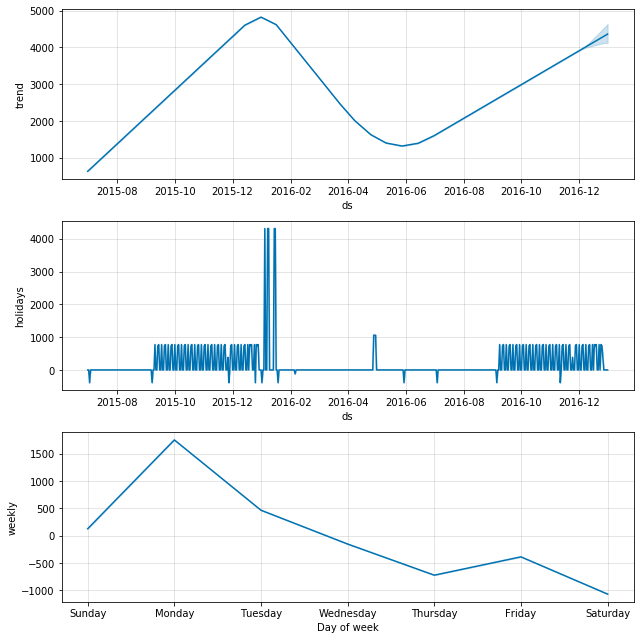

In [0]:
# Python
fig = m.plot_components(forecast);

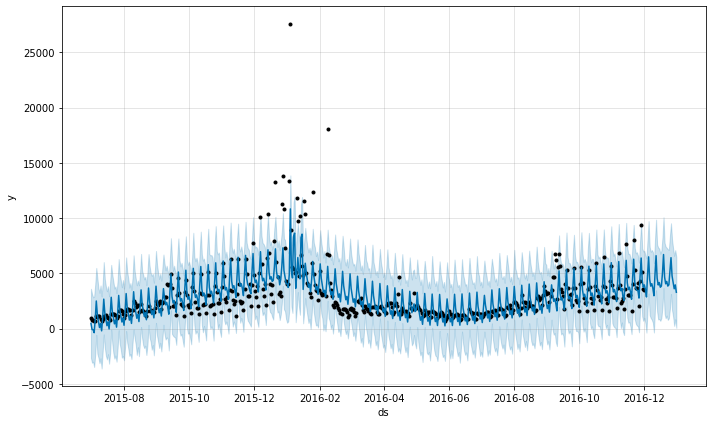

In [0]:
m.plot(forecast, uncertainty=True, plot_cap=True);

In [0]:
cmp_df = make_comparison_dataframe(nfl, forecast)
cmp_df.tail()

yhat   yhat_lower   yhat_upper        y
ds                                                        
2016-12-27  4764.124187  1674.812662  8046.368610  11117.0
2016-12-28  4160.492456  1080.492250  7248.145891   6367.0
2016-12-29  3605.561875   244.322962  6587.356631   4734.0
2016-12-30  3956.063201   843.176451  7102.993606   3883.0
2016-12-31  3289.324488    66.070187  6487.665165   3020.0

In [0]:
for err_name, err_value in calculate_prophet_errors(cmp_df, prediction_size).items():
    print(err_name, err_value)

Prophet model w/ holidays MAPE 29.542083594687046


In [0]:
print('Prophet model w/ holidays SMAPE:{}'.format(smape(cmp_df['y'], cmp_df['yhat'])))

Prophet model w/ holidays SMAPE:34.769428164607184


#### Calendário com as datas mais importantes e regularização

In [0]:
nfl_important = pd.concat((season_nfl,
                           sunday_nfl))

In [0]:
# Python
from fbprophet.plot import plot_weekly
m = Prophet(holidays=nfl_important,
            interval_width=0.95,
            holidays_prior_scale=0.05,
            weekly_seasonality=True,)



In [0]:
forecast = m.fit(train_df1).predict(future)
future = m.make_future_dataframe(periods=prediction_size, freq='D')
forecast = m.predict(future)
forecast.tail()

ds        trend   yhat_lower   yhat_upper  trend_lower  \
545 2016-12-27  4282.716642  1414.659010  7881.246224  4050.397137   
546 2016-12-28  4297.478227   952.222321  7492.501795  4048.206795   
547 2016-12-29  4312.239812   608.864864  6809.007075  4047.847353   
548 2016-12-30  4327.001398   833.182434  7435.532739  4050.676978   
549 2016-12-31  4341.762983     1.298784  6565.920356  4051.415544   

     trend_upper  Season  Season_lower  Season_upper  Sunday_nfl  ...  \
545  4524.327913     0.0           0.0           0.0         0.0  ...   
546  4550.498801     0.0           0.0           0.0         0.0  ...   
547  4578.459381     0.0           0.0           0.0         0.0  ...   
548  4604.166935     0.0           0.0           0.0         0.0  ...   
549  4634.714398     0.0           0.0           0.0         0.0  ...   

     holidays  holidays_lower  holidays_upper       weekly  weekly_lower  \
545       0.0             0.0             0.0   409.876994    409.876994   
546       0.0             0.0             0.0  -207.543849   -207.543849   
547       0.0             0.0             0.0  -614.673738   -614.673738   
548       0.0             0.0             0.0  -340.554848   -340.554848   
549       0.0             0.0             0.0 -1107.984983  -1107.984983   

     weekly_upper  multiplicative_terms  multiplicative_terms_lower  \
545    409.876994                   0.0                         0.0   
546   -207.543849                   0.0                         0.0   
547   -614.673738                   0.0                         0.0   
548   -340.554848                   0.0                         0.0   
549  -1107.984983                   0.0                         0.0   

     multiplicative_terms_upper         yhat  
545                         0.0  4692.593636  
546                         0.0  4089.934378  
547                         0.0  3697.566075  
548                         0.0  3986.446549  
549                         0.0  3233.778000  

[5 rows x 25 columns]

In [0]:
forecast[(forecast['Season'] + forecast['Sunday_nfl']).abs() > 0][
        ['ds', 'Season', 'Sunday_nfl']][-10:]

ds      Season  Sunday_nfl
529 2016-12-11  658.682695   35.875632
530 2016-12-12  658.682695    0.000000
533 2016-12-15  658.682695    0.000000
535 2016-12-17  658.682695    0.000000
536 2016-12-18  658.682695   35.875632
537 2016-12-19  658.682695    0.000000
540 2016-12-22  658.682695    0.000000
542 2016-12-24  658.682695    0.000000
543 2016-12-25  658.682695   35.875632
544 2016-12-26  658.682695    0.000000

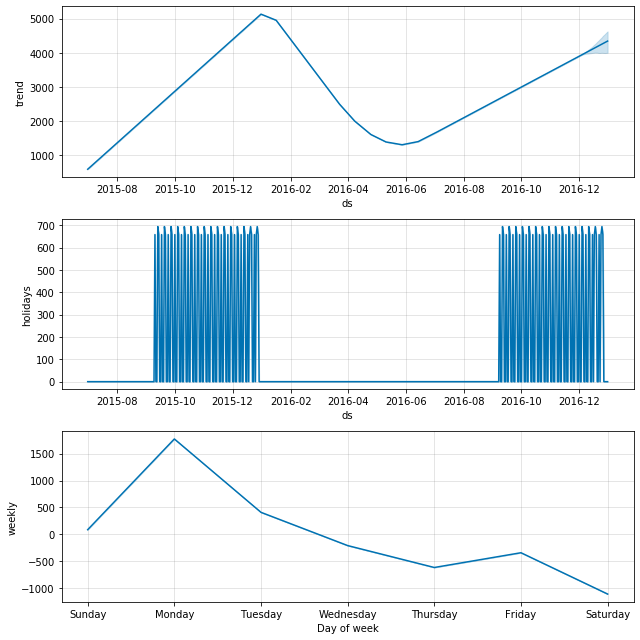

In [0]:
# Python
fig = m.plot_components(forecast);

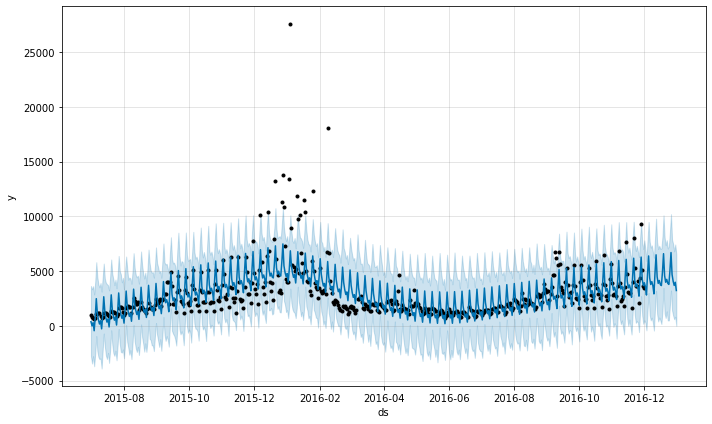

In [0]:
m.plot(forecast, uncertainty=True, plot_cap=True);

In [0]:
cmp_df = make_comparison_dataframe(nfl, forecast)
cmp_df.tail()

yhat   yhat_lower   yhat_upper        y
ds                                                        
2016-12-27  4692.593636  1414.659010  7881.246224  11117.0
2016-12-28  4089.934378   952.222321  7492.501795   6367.0
2016-12-29  3697.566075   608.864864  6809.007075   4734.0
2016-12-30  3986.446549   833.182434  7435.532739   3883.0
2016-12-31  3233.778000     1.298784  6565.920356   3020.0

In [0]:
for err_name, err_value in calculate_prophet_errors(cmp_df, prediction_size).items():
    print(err_name, err_value)

Prophet model w/ holidays MAPE 29.494728696627774


In [0]:
print('Prophet model w/ holidays SMAPE:{}'.format(smape(cmp_df['y'], cmp_df['yhat'])))

Prophet model w/ holidays SMAPE:34.82082021193727


### Outros odelos de Machine Learning

### Feature engineering

In [0]:
# Python
def is_nfl_season(ds):
    date = pd.to_datetime(ds)
    if date.month > 8 or date.month < 2:
        return 1
    else:
        return 0

In [0]:
nfl['on_season'] = nfl['ds'].apply(is_nfl_season)

In [0]:
# Python
def nfl_sunday(ds):
    date = pd.to_datetime(ds)
    if date.weekday() == 6 and (date.month > 8 or date.month < 2):
        return 1
    else:
        return 0

In [0]:
nfl['nfl_sunday'] = nfl['ds'].apply(nfl_sunday)

In [0]:
nfl['y_freq']= nfl.groupby('y')['y'].transform('size')

In [0]:
nfl['quarter']   = pd.DatetimeIndex(nfl.index).quarter
nfl['month']     = pd.DatetimeIndex(nfl.index).month
nfl['weekday']   = pd.DatetimeIndex(nfl.index).weekday
nfl['weekend']   = (nfl['weekday'] // 5 == 1).astype(int)

In [0]:
for i in range(1, 8):
    nfl["lag_{}".format(i)] = nfl.y.shift(i)

In [0]:
nfl = nfl.set_index(pd.DatetimeIndex(nfl['ds']))
nfl.drop(['ds'], axis=1, inplace=True)
nfl.head(8)

y  on_season  nfl_sunday  y_freq  quarter  month  weekday  \
ds                                                                           
2015-07-01   988.0          0           0       1        1      1        3   
2015-07-02   813.0          0           0       1        1      1        3   
2015-07-03   743.0          0           0       1        1      1        3   
2015-07-04   664.0          0           0       1        1      1        3   
2015-07-05   719.0          0           0       1        1      1        3   
2015-07-06  1101.0          0           0       2        1      1        3   
2015-07-07  1080.0          0           0       1        1      1        3   
2015-07-08  1143.0          0           0       1        1      1        3   

            weekend   lag_1   lag_2  lag_3  lag_4  lag_5  lag_6  lag_7  
ds                                                                      
2015-07-01        0     NaN     NaN    NaN    NaN    NaN    NaN    NaN  
2015-07-02        0   988.0     NaN    NaN    NaN    NaN    NaN    NaN  
2015-07-03        0   813.0   988.0    NaN    NaN    NaN    NaN    NaN  
2015-07-04        0   743.0   813.0  988.0    NaN    NaN    NaN    NaN  
2015-07-05        0   664.0   743.0  813.0  988.0    NaN    NaN    NaN  
2015-07-06        0   719.0   664.0  743.0  813.0  988.0    NaN    NaN  
2015-07-07        0  1101.0   719.0  664.0  743.0  813.0  988.0    NaN  
2015-07-08        0  1080.0  1101.0  719.0  664.0  743.0  813.0  988.0

### Implantando os modelos de ML

In [0]:
# for time-series cross-validation set 5 folds 
tscv = TimeSeriesSplit(n_splits=5)

In [0]:
def timeseries_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
    """
    
    # get the index after which test set starts
    test_index = int(len(X)*(1-test_size))
    
    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test

In [0]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

y = nfl.dropna().y
X = nfl.dropna().drop(['y'], axis=1)

X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.2)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [0]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((434, 14), (109, 14), (434,), (109,))

In [0]:
def plotModelResults(model, X_train=X_train, X_test=X_test, plot_intervals=False, plot_anomalies=False):
    """
        Plots modelled vs fact values, prediction intervals and anomalies
    
    """
    
    prediction = model.predict(X_test)
    
    plt.figure(figsize=(20, 10))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()
        
        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)
        
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    error = mean_absolute_percentage_error(prediction, y_test)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);
    
def plotCoefficients(model):
    """
        Plots sorted coefficient values of the model
    """
    
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

In [0]:
from sklearn.pipeline import Pipeline
from sklearn.externals import joblib
from sklearn.linear_model import LogisticRegression
from sklearn import tree
import lightgbm as lgb
import xgboost as xgb
from xgboost import XGBRegressor

In [0]:
def xgb_mape(preds, dtrain):
    labels = dtrain.get_label()
    return('mape', -np.mean(np.abs((labels - preds) / (labels+1))))

In [0]:
# Construct some pipelines
pipe_lr = Pipeline([('clf', LogisticRegression())])

pipe_ridge = Pipeline([('clf', sk.linear_model.Ridge(alpha=1.0))])

pipe_svr = Pipeline([('clf', sk.svm.SVR(kernel = 'linear', C=0.01))])

pipe_dt = Pipeline([('clf', tree.DecisionTreeRegressor(max_depth = 5,
                                                       min_samples_split = 5,
                                                       min_samples_leaf = 5))])

pipe_knn = Pipeline([('clf', sk.neighbors.KNeighborsRegressor(n_neighbors=5, n_jobs=-1))])

pipe_rf = Pipeline([('clf', sk.ensemble.RandomForestRegressor(n_jobs=-1,
                                                              n_estimators = 1000,
                                                              max_depth = 5,
                                                              min_samples_split = 5,
                                                              min_samples_leaf = 5))])

pipe_lgbm = Pipeline([('clf', lgb.LGBMClassifier(objective = 'regression',
                                                 n_jobs=-1,
                                                 max_depth = 5,        # It describes the maximum depth of tree
                                                 n_estimators = 1000))])

pipe_xgb = Pipeline([('clf', XGBRegressor(feval = xgb_mape,
                                          early_stopping_rounds=10,
                                          maximize=False,
                                          n_jobs=-1,
                                          max_depth = 5,
                                          n_estimators = 1000))])

# List of pipelines for ease of iteration
pipelines = [pipe_lr, pipe_ridge, pipe_svr, pipe_dt, pipe_knn, pipe_rf, pipe_lgbm, pipe_xgb]

# Dictionary of pipelines and classifier types for ease of reference
pipe_dict = {0: 'Logistic Regression', 1: 'Ridge Regression', 2: 'SVM',
             3: 'Decision Tree', 4: 'KNN', 5: 'Random Forest',
             6: 'LGbm', 7: 'XGboost'}

[14:02:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:02:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:02:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:02:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:02:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:02:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Logistic Regression pipeline test accuracy: 0.000
Ridge Regression pipeline test accuracy: 0.754
SVM pipeline test accuracy: 0.805
Decision Tree pipeline test accuracy: 0.121
KNN pipeline test accuracy: 0.772
Random Forest pipeline test accuracy: 0.775
LGbm pipeline test accuracy: 0.000
XGboost pipeline

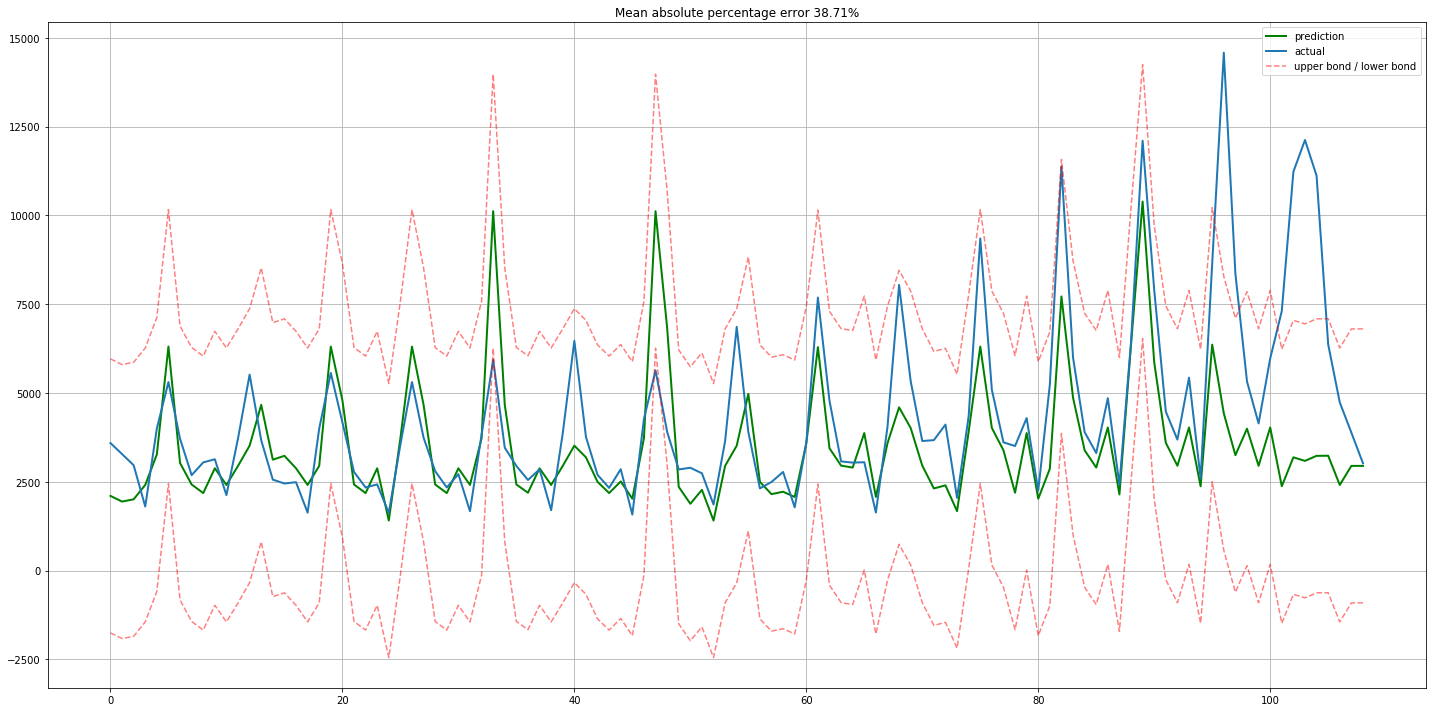

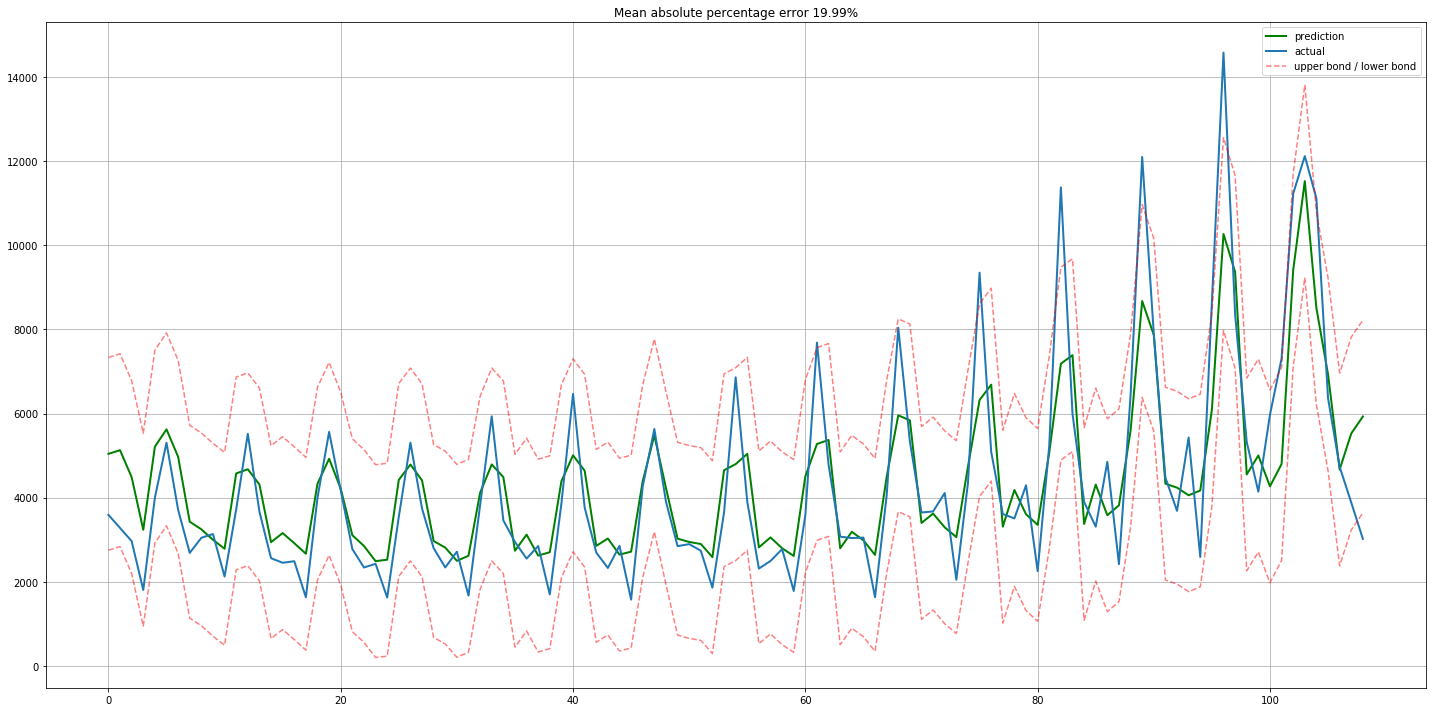

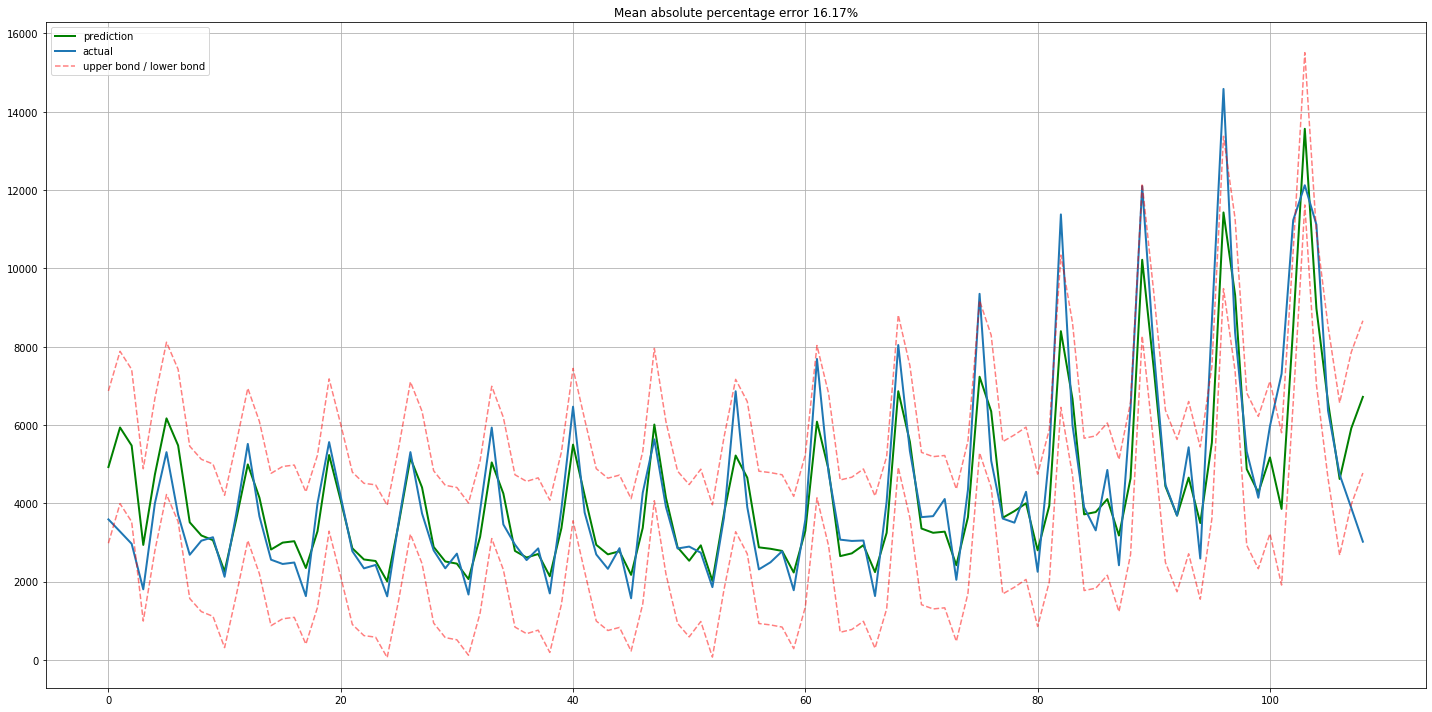

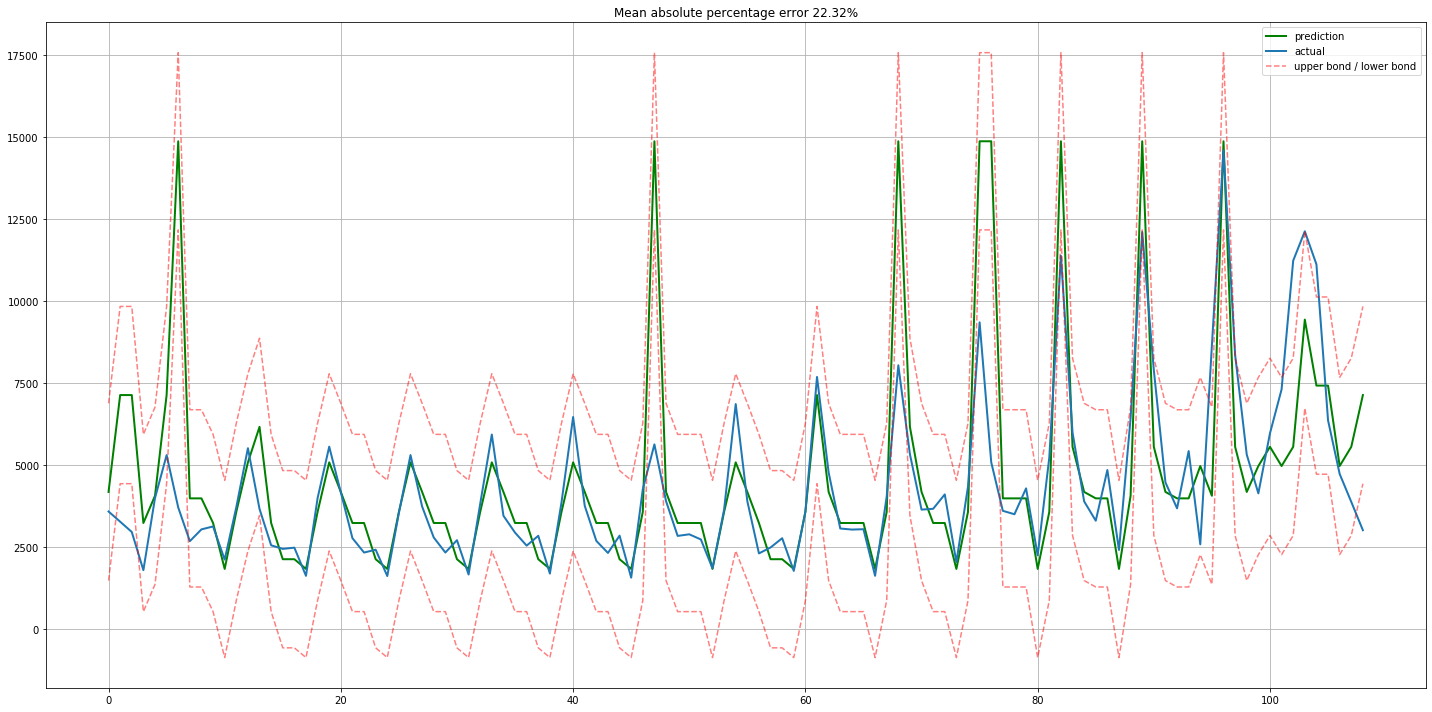

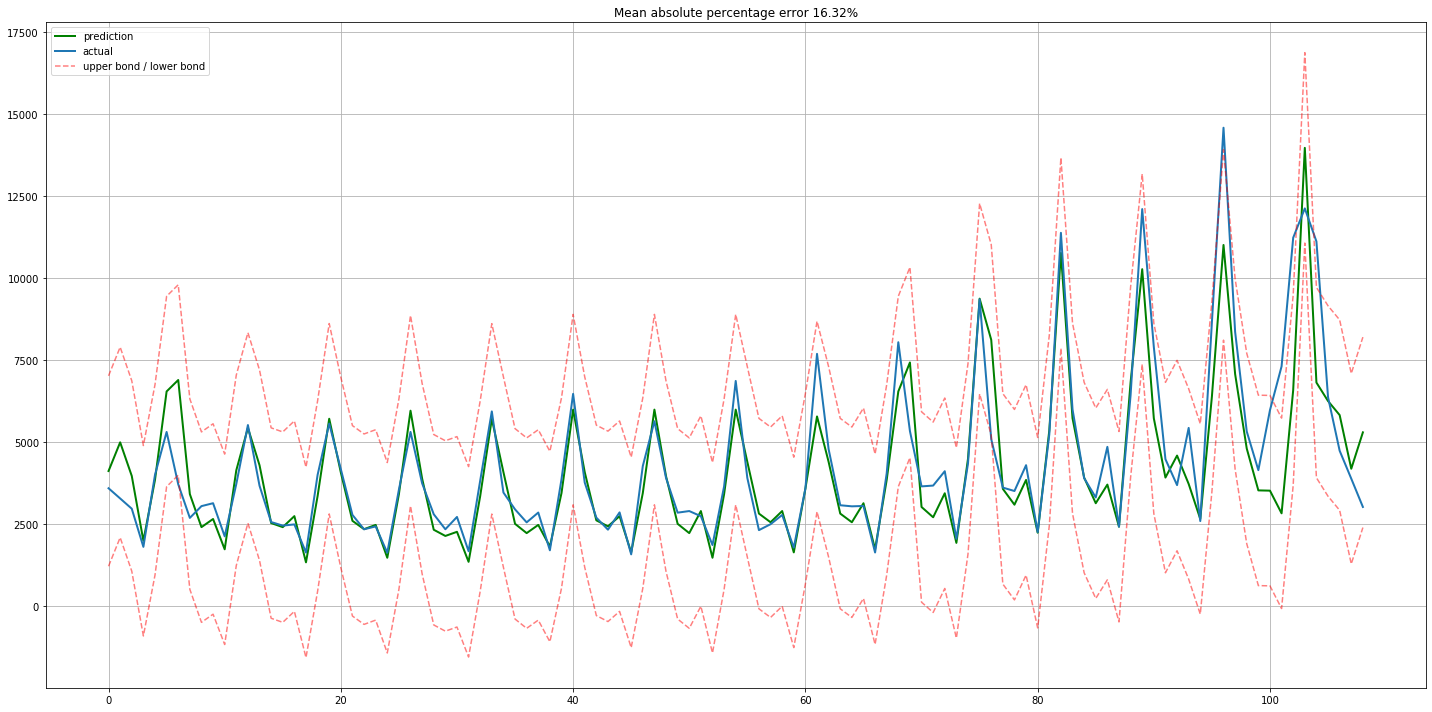

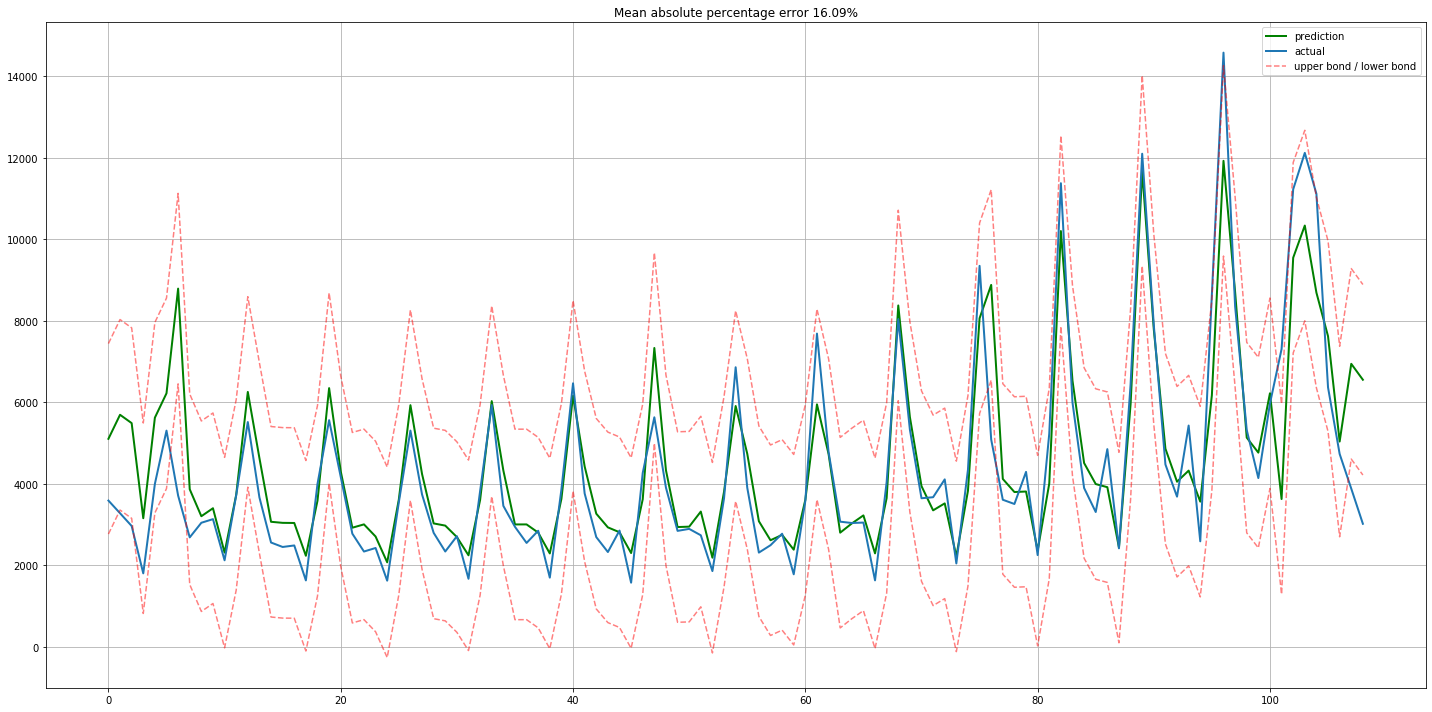

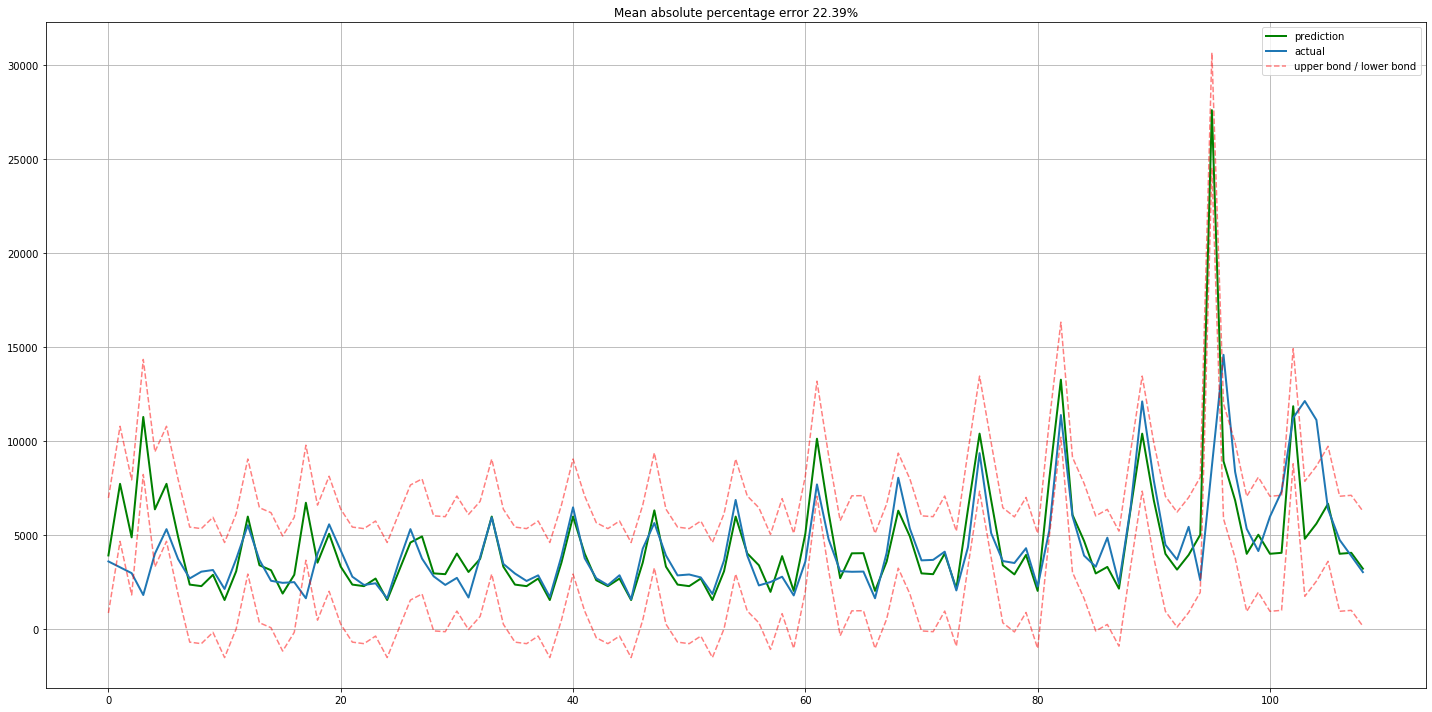

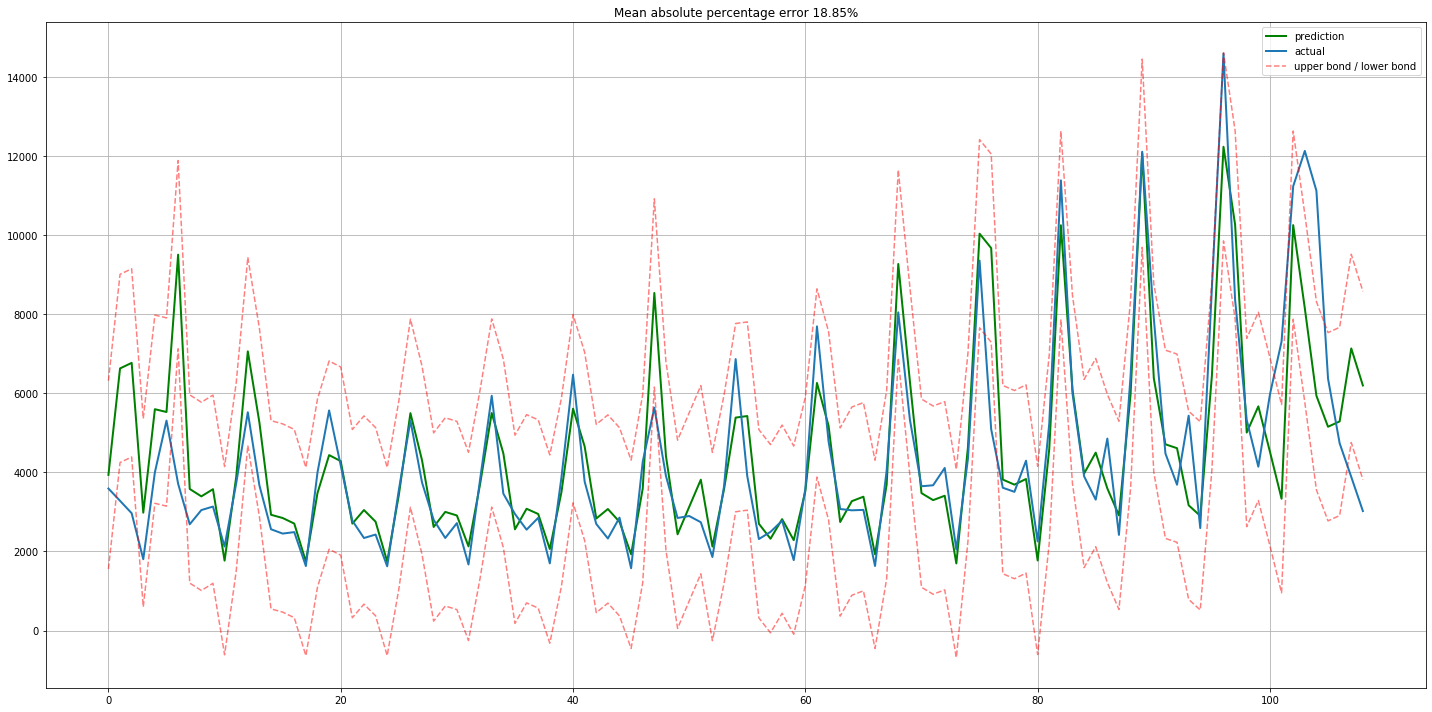

In [0]:
# Fit the pipelines
for pipe in pipelines:
    pipe.fit(X_train, y_train)
    plotModelResults(pipe, plot_intervals=True, plot_anomalies=False)
    #plotCoefficients(pipe)

# Compare accuracies
for idx, val in enumerate(pipelines):
    print('%s pipeline test accuracy: %.3f' % (pipe_dict[idx], val.score(X_test, y_test)))

In [0]:
nfl.columns

Index(['y', 'on_season', 'nfl_sunday', 'y_freq', 'quarter', 'month', 'weekday',
       'weekend', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6',
       'lag_7'],
      dtype='object')

In [0]:
nfl_dl = nfl.reset_index()
nfl_dl.drop(['on_season', 'nfl_sunday', 'y_freq', 'quarter', 'month', 'weekday',
             'weekend', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6',
             'lag_7'], axis=1, inplace = True)
nfl_dl.head()

ds      y
0 2015-07-01  988.0
1 2015-07-02  813.0
2 2015-07-03  743.0
3 2015-07-04  664.0
4 2015-07-05  719.0

## Testando modelo Deep Learning

In [0]:
import keras
from keras.models import Sequential # Create Model
from keras.layers import Dense # Neurons
from keras.layers import LSTM # Long Short Term Memory
from sklearn.preprocessing import MinMaxScaler # Normalize
from sklearn.metrics import mean_squared_error # Loss Function
from sklearn.model_selection import train_test_split

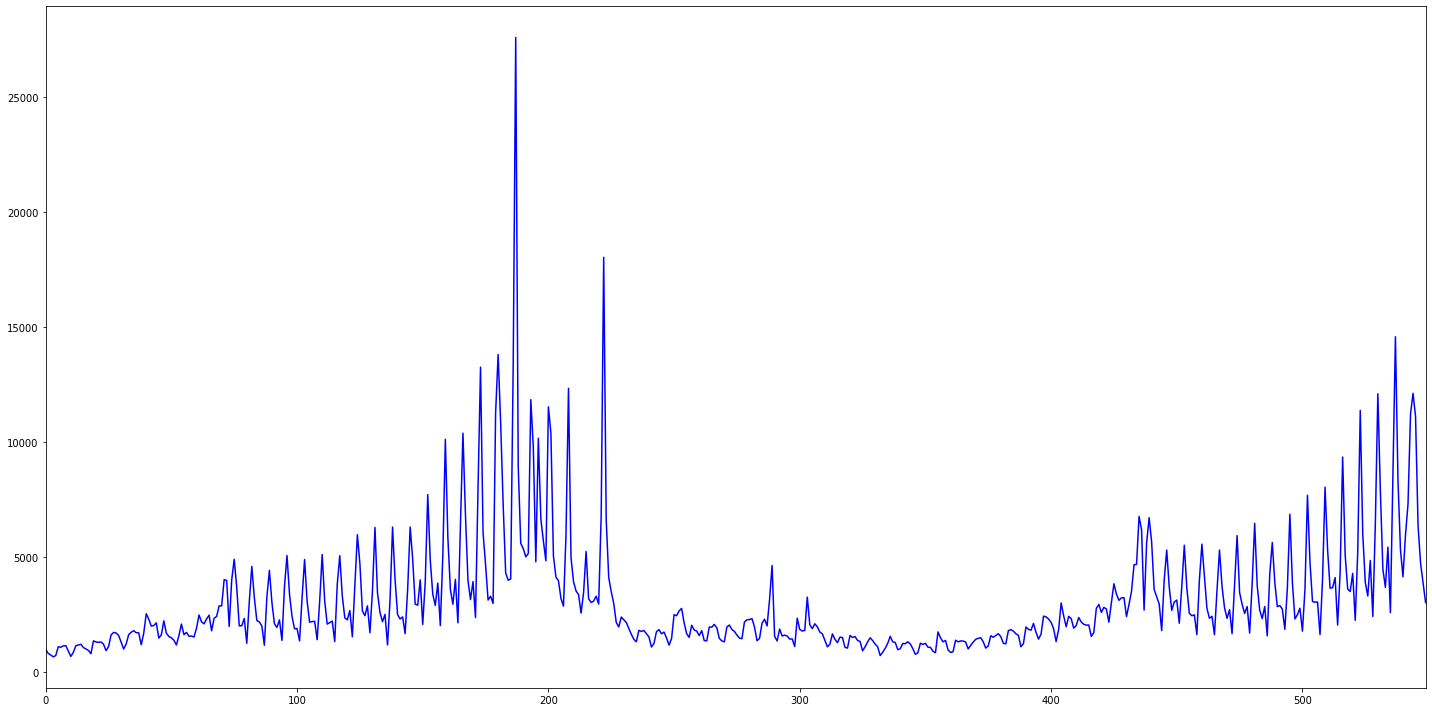

In [0]:
# Print da série diária de visualizações das páginas das temporadas 2014/2015 e 2015/2016 da NFL
fig = plt.figure(facecolor='w', figsize=(20, 10))
ax = fig.add_subplot(111)
sample_series = nfl_dl.y
sample_series.plot(style="-b", ax=ax)
plt.tight_layout();

In [0]:
df = nfl_dl.iloc[:,1].values # We use "Open" column.

In [0]:
df = df.reshape(-1,1)

scaler = MinMaxScaler(feature_range = (0,1)) # Normalize data
df = scaler.fit_transform(df)
np.max(df)

1.0

In [0]:
# Test - Train Split
train_size = int(len(df) * 0.75) # % 75 Train
test_size = len(df) - train_size # % 25 Test
print("Train Size :",train_size,"Test Size :",test_size)

train = df[0:train_size,:]
test = df[train_size:len(df),:]

Train Size : 412 Test Size : 138


In [0]:
time_stemp = 10

datax = []
datay = []
for i in range(len(train)-time_stemp-1):
    a = train[i:(i+time_stemp), 0]
    datax.append(a)
    datay.append(train[i + time_stemp, 0])
trainx = np.array(datax)
trainy = np.array(datay)


datax = []
datay = []
for i in range(len(test)-time_stemp-1):
    a = test[i:(i+time_stemp), 0]
    datax.append(a)
    datay.append(test[i + time_stemp, 0])
testx = np.array(datax)
testy = np.array(datay)

trainx = np.reshape(trainx, (trainx.shape[0], 1, trainx.shape[1])) # For Keras
testx = np.reshape(testx, (testx.shape[0], 1,testx.shape[1])) # For Keras
print(trainx.shape)
testx.shape

(401, 1, 10)


(127, 1, 10)

In [0]:
epochs = 200
model = Sequential()
model.add(LSTM(10, input_shape = (1, time_stemp)))
model.add(Dense(1)) # Output Layer
model.compile(loss = "mean_squared_error", optimizer = "adam")
history = model.fit(trainx,trainy, epochs = epochs, batch_size = 50, verbose=0)
# As you can see, Loss is very little

In [0]:
epoch = np.arange(0, epochs, 10)
losses = []
for i in epoch:
    if i % 10 == 0:
        losses.append(history.history["loss"][i])
        
data = {"epoch":epoch,"loss":losses}
data = pd.DataFrame(data) # Create dataframe for visualize with plotly

# Visualize
import plotly.express as px

fig = px.line(data,x="epoch",y="loss",width = 1200, height = 500)
fig.show()
# I choose plotly for visualize because it's interactive

In [0]:
train_predict = model.predict(trainx)
test_predict = model.predict(testx)

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
trainy = scaler.inverse_transform([trainy])
testy = scaler.inverse_transform([testy])

train_score = (keras.losses.mean_absolute_percentage_error(trainy[0], train_predict[:,0])) # mean_squared_error -> Loss Function
print("Train Score : %4.f MAPE" % (train_score))
test_score = (keras.losses.mean_absolute_percentage_error(testy[0], test_predict[:,0]))
print("Test Score : %4.f MAPE" % (test_score))

Train Score :   19 MAPE
Test Score :   20 MAPE


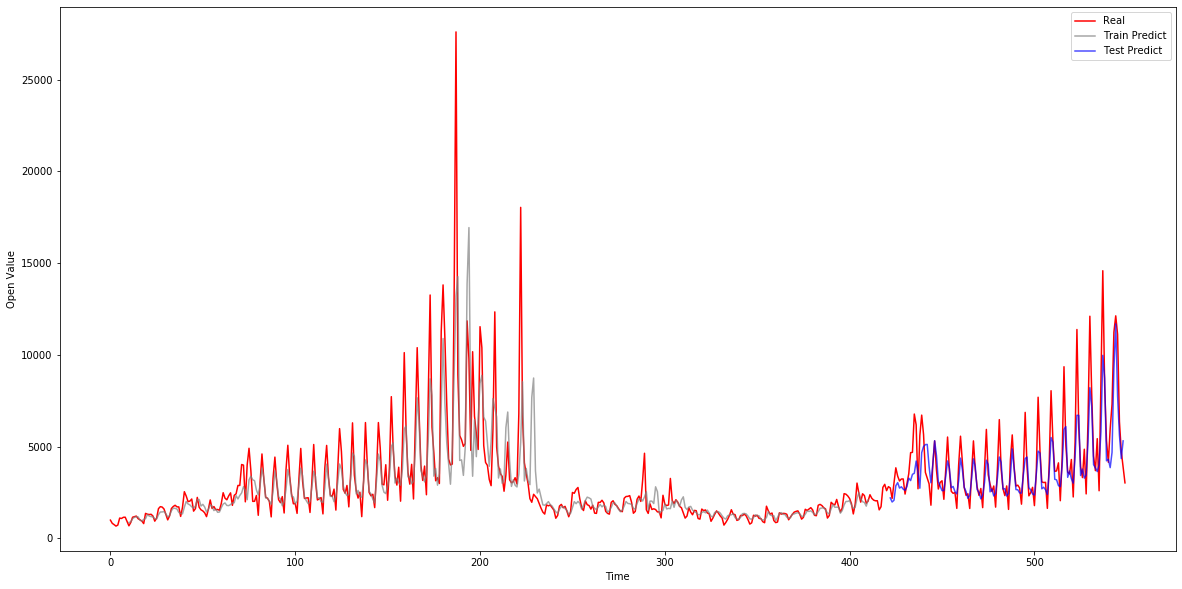

In [0]:
# empty_like -> Return a new array with the same shape and type as a given array.
train_predict_plot = np.empty_like(df)
train_predict_plot[:,:] = np.nan
train_predict_plot[time_stemp:len(train_predict)+time_stemp, :] = train_predict

test_predict_plot = np.empty_like(df)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict)+(time_stemp*2)+1:len(df)-1, :] = test_predict

plt.figure(figsize=(20,10))
plt.plot(scaler.inverse_transform(df),color = "red",label = "Real")
plt.plot(train_predict_plot,label = "Train Predict",color = "gray",alpha = 0.7)
plt.plot(test_predict_plot,label = "Test Predict",color = "blue", alpha = 0.7)
plt.legend()
plt.xlabel("Time")
plt.ylabel("Open Value")
plt.show()